# Random Forest Model for Predicting Indoor Locations

**Datasets**:    UJIIndoorLoc_trainingData.csv (training/validation set), UNJIndoorLoc_validationData.csv (test set)

**Scenario**:    Determine the feasbility of using Wi-Fi fingerprints indoor smartphone locationing.
             
**Goal**:        Benchmark 3 indoor locationing solutions using the UJIIndoorLoc dataset from http://archive.ics.uci.edu/ml/datasets/UJIIndoorLoc. 

In this script, I have used 4 additional classifiers apart from Random Forest. They are: Decision Tree, KNN, Extra Tree, and Voting Classifier.

We are only interested in knowing the mean error for each dataset using all the 5 algorithms for this task.

# Imports

In [1]:
# # Importing all the required libraries
# import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import time
import glob
import math
import pickle
import platform
import os
import os.path
import json
import seaborn as sns

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.naive_bayes import GaussianNB

In [2]:
# Splitting the range values into 2 separate columns, converting those columns to float and then finding the average 
# and then storing it back to LONGITUDE column

def calculate_average(df,flag):
    if flag == 'long':
        df['FIRST'] = df['LONGITUDE'].str.split(',').str[0]
        df['FIRST'] = df['FIRST'].str.slice(1,12)
        df['FIRST'] = pd.to_numeric(df['FIRST'], errors='coerce')
        df['LAST'] = df['LONGITUDE'].str.split(',').str[1]
        df['LAST'] = df['LAST'].str.split('[').str[0]
        df['LAST'] = pd.to_numeric(df['LAST'], errors='coerce')
        df['LONGITUDE'] = (df['FIRST'] + (df['LAST']-0.001))/2
        df.drop(['FIRST','LAST'],axis=1,inplace=True)
    else:
        df['FIRST'] = df['LATITUDE'].str.split(',').str[0]
        df['FIRST'] = df['FIRST'].str.slice(1,12)
        df['FIRST'] = pd.to_numeric(df['FIRST'], errors='coerce')
        df['LAST'] = df['LATITUDE'].str.split(',').str[1]
        df['LAST'] = df['LAST'].str.split('[').str[0]
        df['LAST'] = pd.to_numeric(df['LAST'], errors='coerce')
        df['LATITUDE'] = (df['FIRST'] + (df['LAST']-0.1))/2
        df.drop(['FIRST','LAST'],axis=1,inplace=True)
        df['LATITUDE'] = round(df['LATITUDE'].astype(float),2)
    return df

In [3]:
def euclidean(y_test_pos, y_pred_pos):
    """
    Returns the prediction errors based on euclidean distances for each test 
    example. The prediction error for each test set example is the euclidean 
    distance between the test set's position (ground truth) and the predicted 
    position. A "position" is a pair of LONGITUDE and LATITUDE values, 
    e.g. -7515.92, 4.86489e+06.
    
    Arguments:
    y_test_pos -- test set positions represented by numpy array of shape 
                  (m_test, 2)
    y_pred_pos -- predicted test set position represented by numpy array of 
                  shape (m_test, 2)
    
    Returns:
    D_error -- prediction errors between test set positions and predicted test 
               set positions represented by numpy array of shape (m_train, 1)
    """
    m_test = y_test_pos.shape[0]
    D_error = np.sum((y_test_pos - y_pred_pos)**2, axis = 1)**0.5
    
    return D_error

In [4]:
#--- save best model ---#

#def save_model(model, model_name):
#    model_name_present = glob.glob(model_name) # boolean
#    if not model_name_present:
#        pickle.dump(grid_result, open(model_name, 'wb'))
#    else:
#        print('WARNING: This file already exists.')

In [5]:
# #--- save data ---#
# def save_data(dataframe, filename):
#     file_present = glob.glob(filename) # boolean, file already present?
#     if not file_present:
#         dataframe.to_csv(filename)
#     else:
#         print('WARNING: This file already exists.')

In [6]:
scoring = {'accuracy': 'accuracy',
               'kappa': make_scorer(cohen_kappa_score)}

# Hyperparameters for each classifier

In [7]:
# 'parameters' can be a list of dictionaries for more specificity in 
# hyperparamter combinations to attempt.
# for a list of hyperparameters tried, see "tuning_rf.csv"

#RandomForest hyperparameters: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
hyperparameters1 = {'criterion': ['gini','entropy'], 
                  'max_depth': [None], 
                  'max_features': ['sqrt','log2'],
                  'n_estimators': [60]}


#DecisionTree hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
hyperparameters2 = { 'random_state':[17,42],
                    'criterion':['entropy','log_loss','gini'], 
                    'max_features':['sqrt','log2'],
                    'splitter':['best','random'],
                    'max_depth':[5,10,15,20,25,30,35,40],
                    'min_samples_split':[60,80]}


#KNN hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
hyperparameters3 = {'n_neighbors': [1,5,10],
                    'metric':['minkowski'],
                    'algorithm':['ball_tree','kd_tree','brute'], 
                    'weights':['distance'],
                    'leaf_size':[5,10],
                    'p': [1,2]}

#ExtraTree hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html
hyperparameters4 = { 'random_state':[17,42],
                    'criterion':['entropy','log_loss','gini'], 
                    'max_features':['sqrt','log2'],
                    'splitter':['best','random'],
                    'max_depth':[5,10,15,20,25,30,35,40],
                    'min_samples_split':[20,100]}

#Voting hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
hyperparameters5 = { 'voting':['hard','soft']}

In [8]:
Random_Forest_Dict = {}
Decision_Tree_Dict = {}
KNN_Dict = {}
Extra_Tree_Dict = {}
Voting_Dict = {}

In [9]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

# 1. Import Original Dataset

In [10]:
# Original Dataset
UJIInddorLoc_DF_train = pd.read_csv('trainingData.csv')
UJIInddorLoc_DF_test = pd.read_csv('validationData.csv')

print(UJIInddorLoc_DF_train.shape,UJIInddorLoc_DF_test.shape)

(19937, 529) (1111, 529)


In [11]:
UJIInddorLoc_DF_train

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4864920.778,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4864934.225,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4864949.532,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4864934.093,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4864982.217,0,0,122,2,11,13,1369909710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,...,100,-7485.4686,4864874.716,3,1,1,2,18,10,1371710683
19933,100,100,100,100,100,100,100,100,100,100,...,100,-7390.6206,4864836.056,1,2,140,2,18,10,1371710402
19934,100,100,100,100,100,100,100,100,100,100,...,100,-7516.8415,4864889.291,3,1,13,2,18,10,1371710921
19935,100,100,100,100,100,100,100,100,100,100,...,100,-7537.3219,4864895.776,3,1,113,2,18,10,1371711049


In [12]:
print(UJIInddorLoc_DF_train['LONGITUDE'].head(5))
print("\n",UJIInddorLoc_DF_train['LATITUDE'].head(5))
print("\n",UJIInddorLoc_DF_test['LONGITUDE'].head(5))
print("\n",UJIInddorLoc_DF_test['LATITUDE'].head(5))
UJIInddorLoc_DF_train.describe()

0   -7541.2643
1   -7536.6212
2   -7519.1524
3   -7524.5704
4   -7632.1436
Name: LONGITUDE, dtype: float64

 0    4864920.778
1    4864934.225
2    4864949.532
3    4864934.093
4    4864982.217
Name: LATITUDE, dtype: float64

 0   -7515.916799
1   -7383.867221
2   -7374.302080
3   -7365.824883
4   -7641.499303
Name: LONGITUDE, dtype: float64

 0    4.864890e+06
1    4.864840e+06
2    4.864847e+06
3    4.864843e+06
4    4.864922e+06
Name: LATITUDE, dtype: float64


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,99.823644,99.820936,100.0,100.0,99.613733,97.130461,94.733661,93.820234,94.693936,99.163766,...,100.0,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,5.866842,5.798156,0.0,0.0,8.615657,22.931890,30.541335,33.010404,30.305084,12.634045,...,0.0,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,...,100.0,-7691.338400,4.864746e+06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7594.737000,4.864821e+06,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7423.060900,4.864852e+06,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7359.193000,4.864930e+06,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7300.818990,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


0   -7541.2643
1   -7536.6212
2   -7519.1524
3   -7524.5704
4   -7632.1436
Name: LONGITUDE, dtype: float64 

0   -7515.916799
1   -7383.867221
2   -7374.302080
3   -7365.824883
4   -7641.499303
Name: LONGITUDE, dtype: float64 

0    4864920.778
1    4864934.225
2    4864949.532
3    4864934.093
4    4864982.217
Name: LATITUDE, dtype: float64 

0    4.864890e+06
1    4.864840e+06
2    4.864847e+06
3    4.864843e+06
4    4.864922e+06
Name: LATITUDE, dtype: float64


<AxesSubplot:>

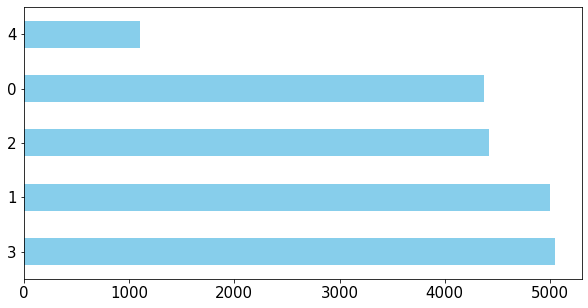

In [13]:
# Find out the avergage of longtitude and latitude for both train and test
if UJIInddorLoc_DF_train['LONGITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_train = calculate_average(UJIInddorLoc_DF_train,'long')

if UJIInddorLoc_DF_test['LONGITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_test = calculate_average(UJIInddorLoc_DF_test,'long')
    
if UJIInddorLoc_DF_train['LATITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_train = calculate_average(UJIInddorLoc_DF_train,'lat')
    
if UJIInddorLoc_DF_test['LATITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_test = calculate_average(UJIInddorLoc_DF_test,'lat')
    
print(UJIInddorLoc_DF_train['LONGITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_test['LONGITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_train['LATITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_test['LATITUDE'].head(5))

Original_DF_FLOOR = UJIInddorLoc_DF_train['FLOOR'].value_counts()
Original_DF_FLOOR.plot(kind='barh', figsize=(10,5), fontsize=15, color='skyblue')

# Evaluate Data
Training/validation Set

In [14]:
print("Building 0",UJIInddorLoc_DF_train.loc[UJIInddorLoc_DF_train["BUILDINGID"] == 0]["FLOOR"].unique()) # building 0 has 4 floors
print("\nBuilding 1",UJIInddorLoc_DF_train.loc[UJIInddorLoc_DF_train["BUILDINGID"] == 1]["FLOOR"].unique()) # building 1 has 4 floors
print("\nBuilding 2",UJIInddorLoc_DF_train.loc[UJIInddorLoc_DF_train["BUILDINGID"] == 2]["FLOOR"].unique()) # building 2 has 5 floors
UJIInddorLoc_DF_train.columns.values

Building 0 [0 2 1 3]

Building 1 [2 0 1 3]

Building 2 [3 2 4 1 0]


array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

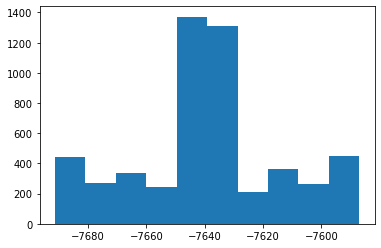

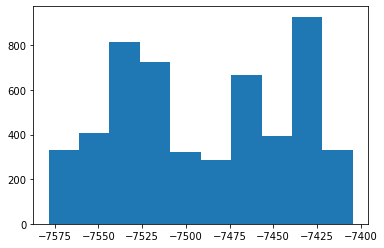

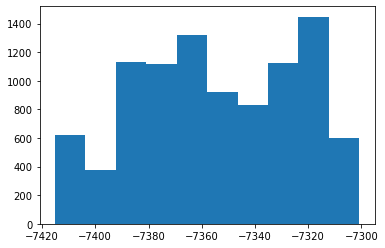

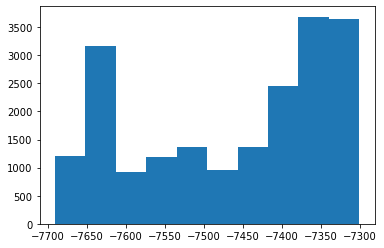

Missing Values: False


In [15]:
plt.hist(UJIInddorLoc_DF_train.loc[UJIInddorLoc_DF_train["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()
# Almost all fingerprints were collected right outside the door to each 
# fingerprint's SPACEID location.
# Building 0 fingerprints were collected by just 2 devices (and 2 separate 
# users). Not a lot of variety in different devices.

plt.hist(UJIInddorLoc_DF_train.loc[UJIInddorLoc_DF_train["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

plt.hist(UJIInddorLoc_DF_train.loc[UJIInddorLoc_DF_train["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

plt.hist(UJIInddorLoc_DF_train["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.


# check for missing values
pd.isnull(UJIInddorLoc_DF_train)
print("Missing Values:",pd.isnull(UJIInddorLoc_DF_train).values.any())


Test Set

In [16]:
print("Building 0",UJIInddorLoc_DF_test.loc[UJIInddorLoc_DF_test["BUILDINGID"] == 0]["FLOOR"].unique()) # building 0 has 4 floors
print("\nBuilding 1",UJIInddorLoc_DF_test.loc[UJIInddorLoc_DF_test["BUILDINGID"] == 1]["FLOOR"].unique()) # building 1 has 4 floors
print("\nBuilding 2",UJIInddorLoc_DF_test.loc[UJIInddorLoc_DF_test["BUILDINGID"] == 2]["FLOOR"].unique()) # building 2 has 5 floors
UJIInddorLoc_DF_test.columns.values

Building 0 [2 1 0 3]

Building 1 [1 3 2 0]

Building 2 [4 2 3 0 1]


array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

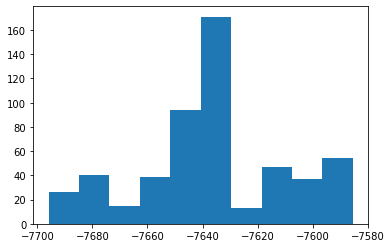

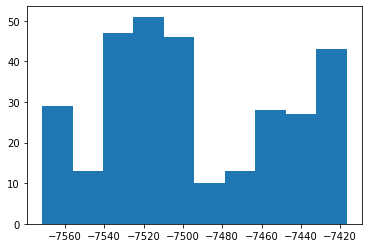

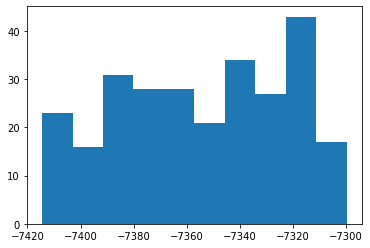

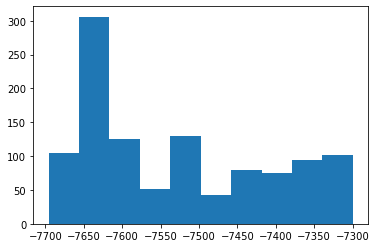

Missing Values: False


In [17]:
plt.hist(UJIInddorLoc_DF_test.loc[UJIInddorLoc_DF_test["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test.loc[UJIInddorLoc_DF_test["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test.loc[UJIInddorLoc_DF_test["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test["LONGITUDE"])
plt.show()

# check for missing values
pd.isnull(UJIInddorLoc_DF_test)
print("Missing Values:",pd.isnull(UJIInddorLoc_DF_test).values.any())

# DATA VISUALIZATION ON ORIGINAL DATASET (Train + Validation)

In [18]:
df_dummy = pd.concat([UJIInddorLoc_DF_train, UJIInddorLoc_DF_train])

In [19]:
print(f"there are {df_dummy['USERID'].nunique()} different users.")
print(f"list of user ids: {df_dummy['USERID'].unique()}\n")
print(f"entries per user:\n{df_dummy['USERID'].value_counts()}")

there are 18 different users.
list of user ids: [ 2 11  3  4  5  6  7  8  9 16 10 12 13 14 15  1 17 18]

entries per user:
11    9032
1     5474
14    3192
7     2766
2     2182
9     2132
16    2064
6     1960
10    1826
13    1682
17    1448
5     1220
8     1014
15     996
18     880
12     874
4      748
3      384
Name: USERID, dtype: int64


In [20]:
print(f"there are {df_dummy['PHONEID'].nunique()} different phones used.")
print(f"list of phone ids: {df_dummy['PHONEID'].unique()}\n")
print(f"entries per phone:\n{df_dummy['PHONEID'].value_counts()}")

there are 16 different phones used.
list of phone ids: [23 13 16 18  3 19  6  1 14  8 24 17  7 11 22 10]

entries per phone:
14    9670
13    9032
7     3192
6     2766
23    2182
19    1960
8     1826
17    1682
22    1448
3     1220
1     1014
11     996
10     880
24     874
18     748
16     384
Name: PHONEID, dtype: int64


<AxesSubplot:ylabel='Count'>

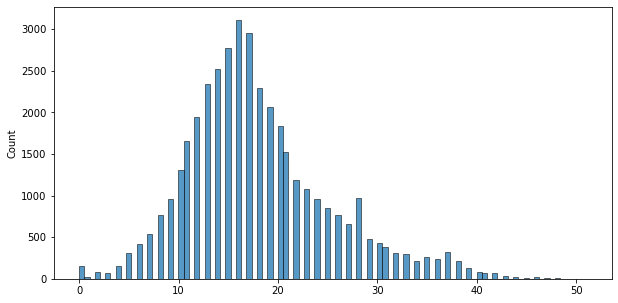

In [21]:
wap_df = df_dummy[df_dummy.columns[:520]]
no_of_waps = wap_df[wap_df != 100].count(axis=1)

plt.figure(figsize=(10,5))
sns.histplot(no_of_waps)

In [22]:
wap_df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
2,100,100,100,100,100,100,100,-97,100,100,...,100,100,100,100,100,100,100,100,100,100
3,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
4,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
19933,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
19934,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
19935,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


<AxesSubplot:xlabel='BUILDINGID', ylabel='count'>

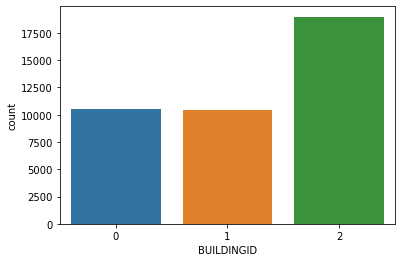

In [23]:
sns.countplot(x=df_dummy['BUILDINGID'])

<AxesSubplot:xlabel='FLOOR', ylabel='count'>

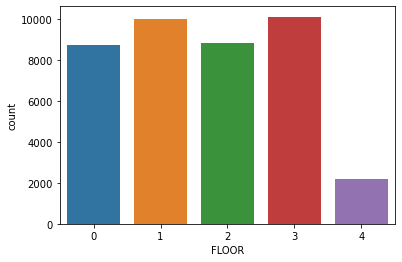

In [24]:
sns.countplot(x=df_dummy['FLOOR'])

In [25]:
temp1 = df_dummy[df_dummy['BUILDINGID']==0].groupby('FLOOR')['SPACEID'].nunique()
temp2 = df_dummy[df_dummy['BUILDINGID']==1].groupby('FLOOR')['SPACEID'].nunique()
temp3 = df_dummy[df_dummy['BUILDINGID']==2].groupby('FLOOR')['SPACEID'].nunique()

print(f"floorwise distribution of spaces in building-0:\n{temp1}\n")
print(f"floorwise distribution of spaces in building-1:\n{temp2}\n")
print(f"floorwise distribution of spaces in building-2:\n{temp3}\n")

floorwise distribution of spaces in building-0:
FLOOR
0    54
1    66
2    68
3    68
Name: SPACEID, dtype: int64

floorwise distribution of spaces in building-1:
FLOOR
0    49
1    38
2    45
3    30
Name: SPACEID, dtype: int64

floorwise distribution of spaces in building-2:
FLOOR
0    44
1    60
2    57
3    91
4    65
Name: SPACEID, dtype: int64



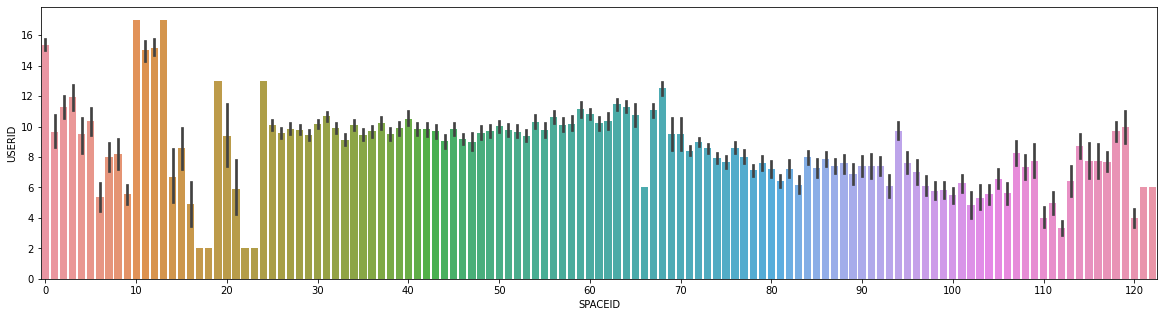

In [26]:
plt.figure(figsize=(20,5))
ax = sns.barplot(data=df_dummy, x='SPACEID', y='USERID')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

# Preprocess Data and Feature Engineering
Training/validation Set

In [27]:
# Fingerprint data representation: positive-value representation for all WAPs.
# Original representation: -104 to 0 (weak to strong), 100 for no signal.
# New represenation: 1 to 105 (weak to strong), 0 for no signal.
UJIInddorLoc_DF_train.iloc[:, 0:520].min().min() # minimum WAP is -104 dBm
train_set_P = UJIInddorLoc_DF_train.copy()
train_set_P.iloc[:, 0:520] = np.where(train_set_P.iloc[:, 0:520] <= 0, 
                train_set_P.iloc[:, 0:520] + 105, 
                train_set_P.iloc[:, 0:520] - 100) 

# Feature Scaling - do not center - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

# Create a single label for the model to predict. FLOOR, LATITUDE, FLOOR, and 
# BUILDINGID pinpoints the exact location of a user inside a building. Stack 
# train set and test set first before assigning unique location so that 
# identical locations are assigned the same UNIQUELOCATION value.
combined = pd.concat([train_set_P, UJIInddorLoc_DF_test]) # stack vertically
combined = combined.assign(UNIQUELOCATION = (combined['LONGITUDE'].astype(str) + '_' + combined['LATITUDE'].astype(str) + '_' + combined['FLOOR'].astype(str) + '_' + combined['BUILDINGID'].astype(str)).astype('category').cat.codes)
len(combined["UNIQUELOCATION"].unique()) # 1997 unique locations

2007

In [28]:
# split again
train_set_PU = combined.iloc[0:19937, :]
test_set_U = combined.iloc[19937:21048, :]

# Change variable types
train_set_PU["UNIQUELOCATION"] = train_set_PU["UNIQUELOCATION"].astype("category")
print(train_set_PU.dtypes)

X_train = train_set_PU.iloc[:, 0:520]
y_train = train_set_PU.iloc[:, 520:530]

WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object


/var/folders/31/mntbwvv97f9b6y8w30p020b00000gn/T/ipykernel_26549/1157588911.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_PU["UNIQUELOCATION"] = train_set_PU["UNIQUELOCATION"].astype("category")


Test Set

In [29]:
# Fingerprint data representation
test_set_PU = test_set_U.copy()
test_set_PU.iloc[:, 0:520] = np.where(test_set_PU.iloc[:, 0:520] <= 0, test_set_PU.iloc[:, 0:520] + 105, test_set_PU.iloc[:, 0:520] - 100) 

# Feature Scaling - do not center this data - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

test_set_PU["UNIQUELOCATION"] = test_set_PU["UNIQUELOCATION"].astype("category")
print(test_set_PU.dtypes)

WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object


In [30]:
X_test = test_set_PU.iloc[:, 0:520]
y_test = test_set_PU.iloc[:, 520:530]

# Create a reference table for looking up the LONGITUDE, LATITUDE, FLOOR, and 
# BUILDINGID associated with each UNIQUELOCATION value.
ref_table = pd.concat([y_train.iloc[:, [0,1,2,3,9]], y_test.iloc[:, [0,1,2,3,9]]])
ref_table = ref_table.drop_duplicates()

#save_data(X_train, 'X_train_rf.csv')
#save_data(y_train, 'y_train_rf.csv')
#save_data(X_test, 'X_test_rf.csv')
#save_data(y_test, 'y_test_rf.csv')

#--- load data ---#
#X_train = pd.read_csv('X_train_rf.csv', index_col = 0)
#y_train = pd.read_csv('y_train_rf.csv', index_col = 0)
#X_test = pd.read_csv('X_test_rf.csv', index_col = 0)
#y_test = pd.read_csv('y_test_rf.csv', index_col = 0)

#-- delete unneeded datasets created during preprocessing to free up memory --#
del UJIInddorLoc_DF_train, train_set_P, train_set_PU, UJIInddorLoc_DF_test, test_set_U, test_set_PU, combined

# 1.1 RANDOM FOREST

In [31]:
file_exists = os.path.exists('Random_Forest_1_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = RandomForestClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters1,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result.best_estimator_)
    print(grid_result.best_score_)
    print(grid_result.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Random_Forest_1_1.json', 'w') as json_file:
        json.dump(grid_result.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['RandomForestClassifier']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [32]:
read = open('Random_Forest_1_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
n_estimators = best[3]

start_train = time.time()
grid_result = RandomForestClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                n_estimators = n_estimators)

# Train the model
grid_result.fit(X_train, y_train.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred = grid_result.predict(X_test)
print("Mean:",np.mean(y_pred == y_test.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
    key = int(ref_table.iloc[i]['UNIQUELOCATION'])
    value = ref_table.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

# position errors for each test set example, in order as they appear
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)

m_test = y_test.shape[0]
mean_error = np.mean(D_error) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error[math.ceil(m_test*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error[math.ceil(m_test*0.50) - 1] # meters
percentile_75th = sorted_D_error[math.ceil(m_test*0.75) - 1] # meters
percentile_95th = sorted_D_error[math.ceil(m_test*0.95) - 1] # meters
percentile_100th = sorted_D_error[math.ceil(m_test*1.00) - 1] # meters
building_hitrate = np.mean(y_test_building == y_pred_building)
floor_hitrate = np.mean(y_test_floor == y_pred_floor)

mean_error_1_1 = np.mean(D_error) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_1_1)
Random_Forest_Dict['Original'] = mean_error_1_1

Best Parameters Saved: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 60}
Mean: 0.0
Mean Error: 8.645534551156816


# 1.2 DECISION TREE

In [33]:
file_exists = os.path.exists('Decision_Tree_1_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = DecisionTreeClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters2,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result.best_estimator_)
    print(grid_result.best_score_)
    print(grid_result.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Decision_Tree_1_2.json', 'w') as json_file:
        json.dump(grid_result.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['DecisionTree']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [34]:
read = open('Decision_Tree_1_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
grid_result = DecisionTreeClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
grid_result.fit(X_train, y_train.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred = grid_result.predict(X_test)
print("Mean:",np.mean(y_pred == y_test.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
    key = int(ref_table.iloc[i]['UNIQUELOCATION'])
    value = ref_table.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

# position errors for each test set example, in order as they appear
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)

m_test = y_test.shape[0]
mean_error = np.mean(D_error) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error[math.ceil(m_test*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error[math.ceil(m_test*0.50) - 1] # meters
percentile_75th = sorted_D_error[math.ceil(m_test*0.75) - 1] # meters
percentile_95th = sorted_D_error[math.ceil(m_test*0.95) - 1] # meters
percentile_100th = sorted_D_error[math.ceil(m_test*1.00) - 1] # meters
building_hitrate = np.mean(y_test_building == y_pred_building)
floor_hitrate = np.mean(y_test_floor == y_pred_floor)

mean_error_1_2 = np.mean(D_error) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_1_2)
Decision_Tree_Dict['Original'] = mean_error_1_2

Best Parameters Saved: {'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 60, 'random_state': 42, 'splitter': 'best'}
Mean: 0.0
Mean Error: 63.31222592905285


# 1.3 KNN

In [35]:
file_exists = os.path.exists('KNN_1_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = KNeighborsClassifier()

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters3,
                        scoring = scoring,
                        cv = 2, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result.best_estimator_)
    print(grid_result.best_score_)
    print(grid_result.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('KNN_1_3.json', 'w') as json_file:
        json.dump(grid_result.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['KNN']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [36]:
read = open('KNN_1_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
grid_result = KNeighborsClassifier(algorithm = algorithm,  leaf_size = leaf_size, metric = metric, \
                                n_neighbors = n_neighbors, p = p, weights = weights)

# Train the model
grid_result.fit(X_train, y_train.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred = grid_result.predict(X_test)
print("Mean:",np.mean(y_pred == y_test.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
    key = int(ref_table.iloc[i]['UNIQUELOCATION'])
    value = ref_table.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

# position errors for each test set example, in order as they appear
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)

m_test = y_test.shape[0]
mean_error = np.mean(D_error) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error[math.ceil(m_test*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error[math.ceil(m_test*0.50) - 1] # meters
percentile_75th = sorted_D_error[math.ceil(m_test*0.75) - 1] # meters
percentile_95th = sorted_D_error[math.ceil(m_test*0.95) - 1] # meters
percentile_100th = sorted_D_error[math.ceil(m_test*1.00) - 1] # meters
building_hitrate = np.mean(y_test_building == y_pred_building)
floor_hitrate = np.mean(y_test_floor == y_pred_floor)

mean_error_1_3 = np.mean(D_error) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_1_3)
KNN_Dict['Original'] = mean_error_1_3

Best Parameters Saved: {'algorithm': 'brute', 'leaf_size': 5, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
Mean: 0.0
Mean Error: 12.118167980573228


# 1.4 EXTRATREE

In [37]:
file_exists = os.path.exists('Extra_Tree_1_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = ExtraTreeClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters4,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result.best_estimator_)
    print(grid_result.best_score_)
    print(grid_result.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Extra_Tree_1_4.json', 'w') as json_file:
        json.dump(grid_result.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['ExtraTree']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [38]:
read = open('Extra_Tree_1_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
grid_result = ExtraTreeClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
grid_result.fit(X_train, y_train.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred = grid_result.predict(X_test)
print("Mean:",np.mean(y_pred == y_test.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
    key = int(ref_table.iloc[i]['UNIQUELOCATION'])
    value = ref_table.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

# position errors for each test set example, in order as they appear
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)

m_test = y_test.shape[0]
mean_error = np.mean(D_error) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error[math.ceil(m_test*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error[math.ceil(m_test*0.50) - 1] # meters
percentile_75th = sorted_D_error[math.ceil(m_test*0.75) - 1] # meters
percentile_95th = sorted_D_error[math.ceil(m_test*0.95) - 1] # meters
percentile_100th = sorted_D_error[math.ceil(m_test*1.00) - 1] # meters
building_hitrate = np.mean(y_test_building == y_pred_building)
floor_hitrate = np.mean(y_test_floor == y_pred_floor)

mean_error_1_4 = np.mean(D_error) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_1_4)
Extra_Tree_Dict['Original'] = mean_error_1_4

Best Parameters Saved: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 20, 'random_state': 42, 'splitter': 'best'}
Mean: 0.0
Mean Error: 20.71474278015889


# 1.5 VOTING

In [39]:
file_exists = os.path.exists('Voting_1_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)])

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters5,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result.best_estimator_)
    print(grid_result.best_score_)
    print(grid_result.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Voting_1_5.json', 'w') as json_file:
        json.dump(grid_result.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['Voting']*cv_results_.shape[0])
#     cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
#                        value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
#     cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
#                        value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [40]:
read = open('Voting_1_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
voting = best[0]

start_train = time.time()
grid_result = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting = voting)

# Train the model
grid_result.fit(X_train, y_train.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred = grid_result.predict(X_test)
print("Mean:",np.mean(y_pred == y_test.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
    key = int(ref_table.iloc[i]['UNIQUELOCATION'])
    value = ref_table.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

# position errors for each test set example, in order as they appear
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)

m_test = y_test.shape[0]
mean_error = np.mean(D_error) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error[math.ceil(m_test*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error[math.ceil(m_test*0.50) - 1] # meters
percentile_75th = sorted_D_error[math.ceil(m_test*0.75) - 1] # meters
percentile_95th = sorted_D_error[math.ceil(m_test*0.95) - 1] # meters
percentile_100th = sorted_D_error[math.ceil(m_test*1.00) - 1] # meters
building_hitrate = np.mean(y_test_building == y_pred_building)
floor_hitrate = np.mean(y_test_floor == y_pred_floor)

mean_error_1_5 = np.mean(D_error) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_1_5)
Voting_Dict['Original'] = mean_error_1_5

Best Parameters Saved: {'voting': 'hard'}


/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean: 0.0
Mean Error: 10.319470106511359


# 2. Import Anonymized Dataset using k-Anonymity. 

In [186]:
# 1st anonymized dataset
UJIInddorLoc_DF_train2 = pd.read_csv('Optimum_Train_4-Anonymity_1_1.csv')
UJIInddorLoc_DF_test2 = pd.read_csv('Optimum_Test_3-Anonymity_2_2.csv')
print(UJIInddorLoc_DF_train2.shape,UJIInddorLoc_DF_test2.shape)

(19937, 529) (1111, 529)


In [187]:
UJIInddorLoc_DF_train2

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864785, 4864805[",3,2,134,2,5,3,1371722823
1,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864785, 4864805[",4,2,122,2,6,19,1371720218
2,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864785, 4864805[",4,2,122,2,6,19,1371720213
3,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864785, 4864805[",4,2,122,2,6,19,1371720213
4,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864785, 4864805[",4,2,122,2,6,19,1371720215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7676[","[4864925, 4864945[",0,0,214,2,1,14,1370878766
19933,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7676[","[4864925, 4864945[",0,0,214,2,1,14,1370878766
19934,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7676[","[4864925, 4864945[",0,0,214,2,1,14,1370878767
19935,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7676[","[4864925, 4864945[",0,0,214,2,1,14,1370878767


In [188]:
print(UJIInddorLoc_DF_train2['LONGITUDE'].head(5))
print("\n",UJIInddorLoc_DF_train2['LATITUDE'].head(5))
print("\n",UJIInddorLoc_DF_test2['LONGITUDE'].head(5))
print("\n",UJIInddorLoc_DF_test2['LATITUDE'].head(5))
UJIInddorLoc_DF_train2.describe()

0    [-7316, -7299.819[
1    [-7316, -7299.819[
2    [-7316, -7299.819[
3    [-7316, -7299.819[
4    [-7316, -7299.819[
Name: LONGITUDE, dtype: object

 0    [4864785, 4864805[
1    [4864785, 4864805[
2    [4864785, 4864805[
3    [4864785, 4864805[
4    [4864785, 4864805[
Name: LATITUDE, dtype: object

 0    [-7336, -7298.787[
1    [-7336, -7298.787[
2    [-7336, -7298.787[
3    [-7336, -7298.787[
4    [-7336, -7298.787[
Name: LONGITUDE, dtype: object

 0    4864776.508
1    4864776.508
2    4864776.508
3    4864776.508
4    4864776.508
Name: LATITUDE, dtype: float64


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP518,WAP519,WAP520,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.000000,19937.000000,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,99.823644,99.820936,100.0,100.0,99.613733,97.130461,94.733661,93.820234,94.693936,99.163766,...,99.788634,99.970507,100.0,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,5.866842,5.798156,0.0,0.0,8.615657,22.931890,30.541335,33.010404,30.305084,12.634045,...,6.360671,2.404232,0.0,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,...,-97.000000,-97.000000,100.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


0   -7307.91
1   -7307.91
2   -7307.91
3   -7307.91
4   -7307.91
Name: LONGITUDE, dtype: float64 

0   -7317.394
1   -7317.394
2   -7317.394
3   -7317.394
4   -7317.394
Name: LONGITUDE, dtype: float64 

0    4864794.95
1    4864794.95
2    4864794.95
3    4864794.95
4    4864794.95
Name: LATITUDE, dtype: float64 

0    4864776.508
1    4864776.508
2    4864776.508
3    4864776.508
4    4864776.508
Name: LATITUDE, dtype: float64


<AxesSubplot:>

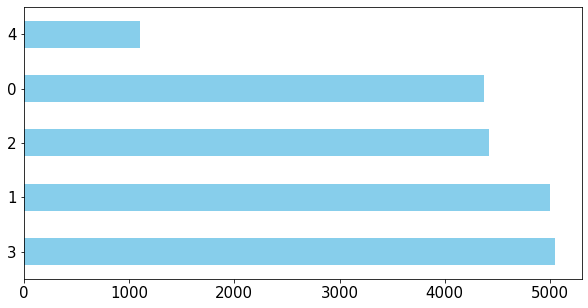

In [189]:
# Find out the avergage of longtitude and latitude for both train and test
if UJIInddorLoc_DF_train2['LONGITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_train2 = calculate_average(UJIInddorLoc_DF_train2,'long')

if UJIInddorLoc_DF_test2['LONGITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_test2 = calculate_average(UJIInddorLoc_DF_test2,'long')
    
if UJIInddorLoc_DF_train2['LATITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_train2 = calculate_average(UJIInddorLoc_DF_train2,'lat')
    
if UJIInddorLoc_DF_test2['LATITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_test2 = calculate_average(UJIInddorLoc_DF_test2,'lat')
    
print(UJIInddorLoc_DF_train2['LONGITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_test2['LONGITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_train2['LATITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_test2['LATITUDE'].head(5))

Original_DF_FLOOR2 = UJIInddorLoc_DF_train2['FLOOR'].value_counts()
Original_DF_FLOOR2.plot(kind='barh', figsize=(10,5), fontsize=15, color='skyblue')

# Evaluate Data
Training/validation Set

In [190]:
print("Building 0",UJIInddorLoc_DF_train2.loc[UJIInddorLoc_DF_train2["BUILDINGID"] == 0]["FLOOR"].unique()) # building 0 has 4 floors
print("\nBuilding 1",UJIInddorLoc_DF_train2.loc[UJIInddorLoc_DF_train2["BUILDINGID"] == 1]["FLOOR"].unique()) # building 1 has 4 floors
print("\nBuilding 2",UJIInddorLoc_DF_train2.loc[UJIInddorLoc_DF_train2["BUILDINGID"] == 2]["FLOOR"].unique()) # building 2 has 5 floors
UJIInddorLoc_DF_train2.columns.values

Building 0 [1 2 3 0]

Building 1 [1 2 3 0]

Building 2 [3 4 1 2 0]


array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

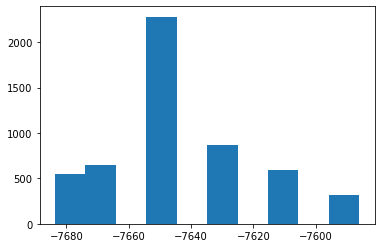

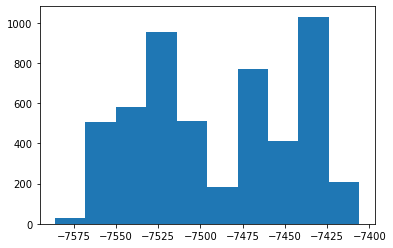

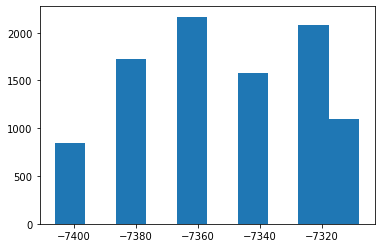

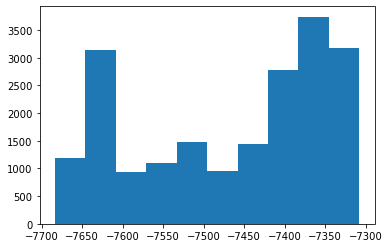

Missing Values: False


In [191]:
plt.hist(UJIInddorLoc_DF_train2.loc[UJIInddorLoc_DF_train2["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()
# Almost all fingerprints were collected right outside the door to each 
# fingerprint's SPACEID location.
# Building 0 fingerprints were collected by just 2 devices (and 2 separate 
# users). Not a lot of variety in different devices.

plt.hist(UJIInddorLoc_DF_train2.loc[UJIInddorLoc_DF_train2["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

plt.hist(UJIInddorLoc_DF_train2.loc[UJIInddorLoc_DF_train2["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

plt.hist(UJIInddorLoc_DF_train2["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.


# check for missing values
pd.isnull(UJIInddorLoc_DF_train2)
print("Missing Values:",pd.isnull(UJIInddorLoc_DF_train2).values.any())


Test Set

In [192]:
print("Building 0",UJIInddorLoc_DF_test2.loc[UJIInddorLoc_DF_test2["BUILDINGID"] == 0]["FLOOR"].unique()) # building 0 has 4 floors
print("\nBuilding 1",UJIInddorLoc_DF_test2.loc[UJIInddorLoc_DF_test2["BUILDINGID"] == 1]["FLOOR"].unique()) # building 1 has 4 floors
print("\nBuilding 2",UJIInddorLoc_DF_test2.loc[UJIInddorLoc_DF_test2["BUILDINGID"] == 2]["FLOOR"].unique()) # building 2 has 5 floors
UJIInddorLoc_DF_test2.columns.values

Building 0 [0 1 2 3]

Building 1 [3 2 0 1]

Building 2 [1 0 3 2 4]


array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

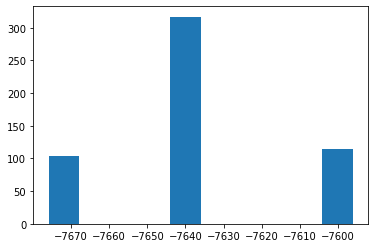

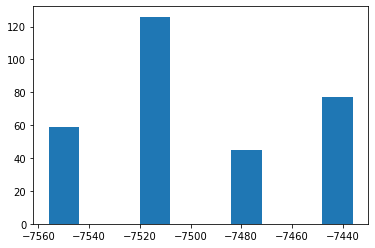

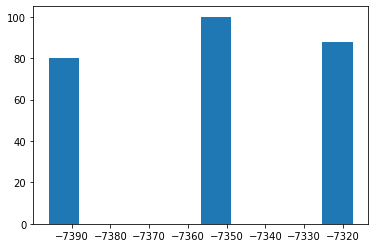

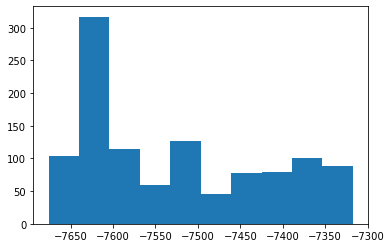

Missing Values: False


In [193]:
plt.hist(UJIInddorLoc_DF_test2.loc[UJIInddorLoc_DF_test2["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test2.loc[UJIInddorLoc_DF_test2["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test2.loc[UJIInddorLoc_DF_test2["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test2["LONGITUDE"])
plt.show()

# check for missing values
pd.isnull(UJIInddorLoc_DF_test2)
print("Missing Values:",pd.isnull(UJIInddorLoc_DF_test2).values.any())

# Preprocess Data and Feature Engineering
Training/validation Set

In [194]:
# Fingerprint data representation: positive-value representation for all WAPs.
# Original representation: -104 to 0 (weak to strong), 100 for no signal.
# New represenation: 1 to 105 (weak to strong), 0 for no signal.
UJIInddorLoc_DF_train2.iloc[:, 0:520].min().min() # minimum WAP is -104 dBm
train_set_P2 = UJIInddorLoc_DF_train2.copy()
train_set_P2.iloc[:, 0:520] = np.where(train_set_P2.iloc[:, 0:520] <= 0, 
                train_set_P2.iloc[:, 0:520] + 105, 
                train_set_P2.iloc[:, 0:520] - 100) 

# Feature Scaling - do not center - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

# Create a single label for the model to predict. FLOOR, LATITUDE, FLOOR, and 
# BUILDINGID pinpoints the exact location of a user inside a building. Stack 
# train set and test set first before assigning unique location so that 
# identical locations are assigned the same UNIQUELOCATION value.
combined2 = pd.concat([train_set_P2, UJIInddorLoc_DF_test2]) # stack vertically
combined2 = combined2.assign(UNIQUELOCATION = (combined2['LONGITUDE'].astype(str) + '_' + combined2['LATITUDE'].astype(str) + '_' + combined2['FLOOR'].astype(str) + '_' + combined2['BUILDINGID'].astype(str)).astype('category').cat.codes)
len(combined2["UNIQUELOCATION"].unique()) # 287 unique locations

335

In [195]:
# split again
train_set_PU2 = combined2.iloc[0:19937, :]
test_set_U2 = combined2.iloc[19937:21048, :]

# Change variable types
train_set_PU2["UNIQUELOCATION"] = train_set_PU2["UNIQUELOCATION"].astype("category")
print(train_set_PU2.dtypes)

X_train2 = train_set_PU2.iloc[:, 0:520]
y_train2 = train_set_PU2.iloc[:, 520:530]

WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object


/var/folders/31/mntbwvv97f9b6y8w30p020b00000gn/T/ipykernel_26549/1631687449.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_PU2["UNIQUELOCATION"] = train_set_PU2["UNIQUELOCATION"].astype("category")


Test Set

In [196]:
# Fingerprint data representation
test_set_PU2 = test_set_U2.copy()
test_set_PU2.iloc[:, 0:520] = np.where(test_set_PU2.iloc[:, 0:520] <= 0, test_set_PU2.iloc[:, 0:520] + 105, test_set_PU2.iloc[:, 0:520] - 100) 

# Feature Scaling - do not center this data - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

test_set_PU2["UNIQUELOCATION"] = test_set_PU2["UNIQUELOCATION"].astype("category")
print(test_set_PU2.dtypes)

WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object


In [197]:
X_test2 = test_set_PU2.iloc[:, 0:520]
y_test2 = test_set_PU2.iloc[:, 520:530]

# Create a reference table for looking up the LONGITUDE, LATITUDE, FLOOR, and 
# BUILDINGID associated with each UNIQUELOCATION value.
ref_table2 = pd.concat([y_train2.iloc[:, [0,1,2,3,9]], y_test2.iloc[:, [0,1,2,3,9]]])
ref_table2 = ref_table2.drop_duplicates()

#save_data(X_train2, 'X_train_rf2.csv')
#save_data(y_train2, 'y_train_rf2.csv')
#save_data(X_test2, 'X_test_rf2.csv')
#save_data(y_test2, 'y_test_rf2.csv')

#--- load data ---#
#X_train2 = pd.read_csv('X_train_rf2.csv', index_col = 0)
#y_train2 = pd.read_csv('y_train_rf2.csv', index_col = 0)
#X_test2 = pd.read_csv('X_test_rf2.csv', index_col = 0)
#y_test2 = pd.read_csv('y_test_rf2.csv', index_col = 0)

#-- delete unneeded datasets created during preprocessing to free up memory --#
del UJIInddorLoc_DF_train2, train_set_P2, train_set_PU2, UJIInddorLoc_DF_test2, test_set_U2, test_set_PU2, combined2

# 2.1 RANDOM FOREST

In [198]:
file_exists = os.path.exists('Random_Forest_2_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = RandomForestClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters1,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result2 = grid.fit(X_train2, y_train2.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result2.best_estimator_)
    print(grid_result2.best_score_)
    print(grid_result2.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Random_Forest_2_1.json', 'w') as json_file:
        json.dump(grid_result2.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result2.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['RandomForestClassifier']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [199]:
read = open('Random_Forest_2_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
n_estimators = best[3]

start_train = time.time()
grid_result2 = RandomForestClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                n_estimators = n_estimators)

# Train the model
grid_result2.fit(X_train2, y_train2.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred2 = grid_result2.predict(X_test2)
print("Mean:",np.mean(y_pred2 == y_test2.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos2 = y_test2.iloc[:, 0:2].values 
y_test_floor2 = y_test2.iloc[:, 2].values
y_test_building2 = y_test2.iloc[:, 3].values

dict_loc = {}
m_total = ref_table2.shape[0]
for i in range(m_total):
    key = int(ref_table2.iloc[i]['UNIQUELOCATION'])
    value = ref_table2.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 0:2] 
y_pred_floor2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 2]
y_pred_building2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 3]

# position errors for each test set example, in order as they appear
D_error2 = euclidean(y_test_pos2, y_pred_pos2)
# sorted   
sorted_D_error2 = sorted(D_error2)

m_test2 = y_test2.shape[0]
mean_error2 = np.mean(D_error2) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error2[math.ceil(m_test2*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error2[math.ceil(m_test2*0.50) - 1] # meters
percentile_75th = sorted_D_error2[math.ceil(m_test2*0.75) - 1] # meters
percentile_95th = sorted_D_error2[math.ceil(m_test2*0.95) - 1] # meters
percentile_100th = sorted_D_error2[math.ceil(m_test2*1.00) - 1] # meters
building_hitrate2 = np.mean(y_test_building2 == y_pred_building2)
floor_hitrate2 = np.mean(y_test_floor2 == y_pred_floor2)

mean_error_2_1 = np.mean(D_error) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_2_1)
Random_Forest_Dict['k-Anonymity'] = mean_error_2_1

Best Parameters Saved: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 60}
Mean: 0.0
Mean Error: 10.319470106511359


# 2.2 DECISION TREE

In [200]:
file_exists = os.path.exists('Decision_Tree_2_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = DecisionTreeClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters2,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result2 = grid.fit(X_train2, y_train2.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result2.best_estimator_)
    print(grid_result2.best_score_)
    print(grid_result2.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Decision_Tree_2_2.json', 'w') as json_file:
        json.dump(grid_result2.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result2.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['DecisionTree']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [201]:
read = open('Decision_Tree_1_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
grid_result2 = DecisionTreeClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
grid_result2.fit(X_train2, y_train2.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred2 = grid_result2.predict(X_test2)
print("Mean:",np.mean(y_pred2 == y_test2.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos2 = y_test2.iloc[:, 0:2].values 
y_test_floor2 = y_test2.iloc[:, 2].values
y_test_building2 = y_test2.iloc[:, 3].values

dict_loc = {}
m_total = ref_table2.shape[0]
for i in range(m_total):
    key = int(ref_table2.iloc[i]['UNIQUELOCATION'])
    value = ref_table2.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 0:2] 
y_pred_floor2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 2]
y_pred_building2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 3]

# position errors for each test set example, in order as they appear
D_error2 = euclidean(y_test_pos2, y_pred_pos2)
# sorted   
sorted_D_error2 = sorted(D_error2)

m_test2 = y_test2.shape[0]
mean_error2 = np.mean(D_error2) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error2[math.ceil(m_test2*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error2[math.ceil(m_test2*0.50) - 1] # meters
percentile_75th = sorted_D_error2[math.ceil(m_test2*0.75) - 1] # meters
percentile_95th = sorted_D_error2[math.ceil(m_test2*0.95) - 1] # meters
percentile_100th = sorted_D_error2[math.ceil(m_test2*1.00) - 1] # meters
building_hitrate2 = np.mean(y_test_building2 == y_pred_building2)
floor_hitrate2 = np.mean(y_test_floor2 == y_pred_floor2)

mean_error_2_2 = np.mean(D_error2) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_2_2)
Decision_Tree_Dict['k-Anonymity'] = mean_error_2_2

Best Parameters Saved: {'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 60, 'random_state': 42, 'splitter': 'best'}
Mean: 0.0
Mean Error: 46.33538074449667


# 2.3 KNN

In [202]:
file_exists = os.path.exists('KNN_2_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = KNeighborsClassifier()

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters3,
                        scoring = scoring,
                        cv = 2, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result2 = grid.fit(X_train2, y_train2.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result2.best_estimator_)
    print(grid_result2.best_score_)
    print(grid_result2.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('KNN_2_3.json', 'w') as json_file:
        json.dump(grid_result2.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result2.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['KNN']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [203]:
read = open('KNN_2_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
grid_result2 = KNeighborsClassifier(algorithm = algorithm,  leaf_size = leaf_size, metric = metric, \
                                n_neighbors = n_neighbors, p = p, weights = weights)

# Train the model
grid_result2.fit(X_train2, y_train2.iloc[:, 9].squeeze())


#--- test set metrics ---#
y_pred2 = grid_result2.predict(X_test2)
print("Mean:",np.mean(y_pred2 == y_test2.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos2 = y_test2.iloc[:, 0:2].values 
y_test_floor2 = y_test2.iloc[:, 2].values
y_test_building2 = y_test2.iloc[:, 3].values

dict_loc = {}
m_total = ref_table2.shape[0]
for i in range(m_total):
    key = int(ref_table2.iloc[i]['UNIQUELOCATION'])
    value = ref_table2.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 0:2] 
y_pred_floor2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 2]
y_pred_building2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 3]

# position errors for each test set example, in order as they appear
D_error2 = euclidean(y_test_pos2, y_pred_pos2)
# sorted   
sorted_D_error2 = sorted(D_error2)

m_test2 = y_test2.shape[0]
mean_error2 = np.mean(D_error2) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error2[math.ceil(m_test2*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error2[math.ceil(m_test2*0.50) - 1] # meters
percentile_75th = sorted_D_error2[math.ceil(m_test2*0.75) - 1] # meters
percentile_95th = sorted_D_error2[math.ceil(m_test2*0.95) - 1] # meters
percentile_100th = sorted_D_error2[math.ceil(m_test2*1.00) - 1] # meters
building_hitrate2 = np.mean(y_test_building2 == y_pred_building2)
floor_hitrate2 = np.mean(y_test_floor2 == y_pred_floor2)

mean_error_2_3 = np.mean(D_error2) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_2_3)
KNN_Dict['k-Anonymity'] = mean_error_2_3

Best Parameters Saved: {'algorithm': 'kd_tree', 'leaf_size': 5, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
Mean: 0.0
Mean Error: 24.722158142247345


# 2.4 EXTRA TREE

In [204]:
file_exists = os.path.exists('Extra_Tree_2_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = ExtraTreeClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters4,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result2 = grid.fit(X_train2, y_train2.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result2.best_estimator_)
    print(grid_result2.best_score_)
    print(grid_result2.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Extra_Tree_2_4.json', 'w') as json_file:
        json.dump(grid_result.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result2.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['ExtraTree']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [205]:
read = open('Extra_Tree_2_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
grid_result2 = ExtraTreeClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
grid_result2.fit(X_train2, y_train2.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred2 = grid_result2.predict(X_test2)
print("Mean:",np.mean(y_pred2 == y_test2.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos2 = y_test2.iloc[:, 0:2].values 
y_test_floor2 = y_test2.iloc[:, 2].values
y_test_building2 = y_test2.iloc[:, 3].values

dict_loc = {}
m_total = ref_table2.shape[0]
for i in range(m_total):
    key = int(ref_table2.iloc[i]['UNIQUELOCATION'])
    value = ref_table2.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 0:2] 
y_pred_floor2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 2]
y_pred_building2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 3]

# position errors for each test set example, in order as they appear
D_error2 = euclidean(y_test_pos2, y_pred_pos2)
# sorted   
sorted_D_error2 = sorted(D_error2)

m_test2 = y_test2.shape[0]
mean_error2 = np.mean(D_error2) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error2[math.ceil(m_test2*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error2[math.ceil(m_test2*0.50) - 1] # meters
percentile_75th = sorted_D_error2[math.ceil(m_test2*0.75) - 1] # meters
percentile_95th = sorted_D_error2[math.ceil(m_test2*0.95) - 1] # meters
percentile_100th = sorted_D_error2[math.ceil(m_test2*1.00) - 1] # meters
building_hitrate2 = np.mean(y_test_building2 == y_pred_building2)
floor_hitrate2 = np.mean(y_test_floor2 == y_pred_floor2)

mean_error_2_4 = np.mean(D_error2) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_2_4)
Extra_Tree_Dict['k-Anonymity'] = mean_error_2_4

Best Parameters Saved: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 20, 'random_state': 42, 'splitter': 'best'}
Mean: 0.0
Mean Error: 30.00653665548994


# 2.5 VOTING

In [206]:
file_exists = os.path.exists('Voting_2_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)])

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters5,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result2 = grid.fit(X_train2, y_train2.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result2.best_estimator_)
    print(grid_result2.best_score_)
    print(grid_result2.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Voting_2_5.json', 'w') as json_file:
        json.dump(grid_result2.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result2.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['Voting']*cv_results_.shape[0])
#     cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
#                        value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
#     cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
#                        value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [207]:
read = open('Voting_2_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
voting = best[0]

start_train = time.time()
grid_result2 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting = voting)

# Train the model
grid_result2.fit(X_train2, y_train2.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred2 = grid_result2.predict(X_test2)
print("Mean:",np.mean(y_pred2 == y_test2.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos2 = y_test2.iloc[:, 0:2].values 
y_test_floor2 = y_test2.iloc[:, 2].values
y_test_building2 = y_test2.iloc[:, 3].values

dict_loc = {}
m_total = ref_table2.shape[0]
for i in range(m_total):
    key = int(ref_table2.iloc[i]['UNIQUELOCATION'])
    value = ref_table2.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 0:2] 
y_pred_floor2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 2]
y_pred_building2 = np.asarray([dict_loc[i] for i in y_pred2])[:, 3]

# position errors for each test set example, in order as they appear
D_error2 = euclidean(y_test_pos2, y_pred_pos2)
# sorted   
sorted_D_error2 = sorted(D_error2)

m_test2 = y_test2.shape[0]
mean_error2 = np.mean(D_error2) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error2[math.ceil(m_test2*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error2[math.ceil(m_test2*0.50) - 1] # meters
percentile_75th = sorted_D_error2[math.ceil(m_test2*0.75) - 1] # meters
percentile_95th = sorted_D_error2[math.ceil(m_test2*0.95) - 1] # meters
percentile_100th = sorted_D_error2[math.ceil(m_test2*1.00) - 1] # meters
building_hitrate2 = np.mean(y_test_building2 == y_pred_building2)
floor_hitrate2 = np.mean(y_test_floor2 == y_pred_floor2)

mean_error_2_5 = np.mean(D_error2) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_2_5)
Voting_Dict['k-Anonymity'] = mean_error_2_5

Best Parameters Saved: {'voting': 'hard'}


/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean: 0.0
Mean Error: 22.41302848138435


# 3. Import Anonymized Dataset using population uniqueness

In [433]:
# 3rd anonymized dataset
UJIInddorLoc_DF_train3 = pd.read_csv('Optimum_Train_Population-uniqueness_1_1.csv')
UJIInddorLoc_DF_test3 = pd.read_csv('Optimum_Test_Population-uniqueness_1_1.csv')

print(UJIInddorLoc_DF_train3.shape,UJIInddorLoc_DF_test3.shape)

(19937, 529) (1111, 529)


In [434]:
UJIInddorLoc_DF_train3

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,-92,100,100,100,100,100,...,100,"[-7321, -7299.819[","[4864770, 4864795[",4,2,141,1,6,19,1371721044
1,100,100,100,100,-92,100,100,100,100,100,...,100,"[-7321, -7299.819[","[4864770, 4864795[",4,2,141,1,6,19,1371721040
2,100,100,100,100,-92,100,100,100,100,100,...,100,"[-7321, -7299.819[","[4864770, 4864795[",4,2,141,1,6,19,1371721041
3,100,100,100,100,-92,100,100,100,100,100,...,100,"[-7321, -7299.819[","[4864770, 4864795[",4,2,141,1,6,19,1371721041
4,100,100,100,100,-92,100,100,100,100,100,...,100,"[-7321, -7299.819[","[4864770, 4864795[",4,2,141,1,6,19,1371721042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7671[","[4864920, 4864945[",0,0,213,2,1,14,1370878785
19933,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7671[","[4864920, 4864945[",0,0,213,2,1,14,1370878786
19934,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7671[","[4864920, 4864945[",0,0,213,2,1,14,1370878786
19935,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7671[","[4864920, 4864945[",0,0,213,2,1,14,1370878787


In [435]:
print(UJIInddorLoc_DF_train3['LONGITUDE'].head(5))
print("\n",UJIInddorLoc_DF_train3['LATITUDE'].head(5))
print("\n",UJIInddorLoc_DF_test3['LONGITUDE'].head(5))
print("\n",UJIInddorLoc_DF_test3['LATITUDE'].head(5))
UJIInddorLoc_DF_train3.describe()

0    [-7321, -7299.819[
1    [-7321, -7299.819[
2    [-7321, -7299.819[
3    [-7321, -7299.819[
4    [-7321, -7299.819[
Name: LONGITUDE, dtype: object

 0    [4864770, 4864795[
1    [4864770, 4864795[
2    [4864770, 4864795[
3    [4864770, 4864795[
4    [4864770, 4864795[
Name: LATITUDE, dtype: object

 0    [-7306, -7298.787[
1    [-7306, -7298.787[
2        [-7316, -7306[
3        [-7316, -7306[
4        [-7316, -7306[
Name: LONGITUDE, dtype: object

 0    [4864795, 4864820[
1    [4864795, 4864820[
2    [4864770, 4864795[
3    [4864770, 4864795[
4    [4864770, 4864795[
Name: LATITUDE, dtype: object


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP518,WAP519,WAP520,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.000000,19937.000000,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,99.823644,99.820936,100.0,100.0,99.613733,97.130461,94.733661,93.820234,94.693936,99.163766,...,99.788634,99.970507,100.0,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,5.866842,5.798156,0.0,0.0,8.615657,22.931890,30.541335,33.010404,30.305084,12.634045,...,6.360671,2.404232,0.0,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,...,-97.000000,-97.000000,100.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


0   -7310.41
1   -7310.41
2   -7310.41
3   -7310.41
4   -7310.41
Name: LONGITUDE, dtype: float64 

0   -7302.3940
1   -7302.3940
2   -7311.0005
3   -7311.0005
4   -7311.0005
Name: LONGITUDE, dtype: float64 

0    4864782.45
1    4864782.45
2    4864782.45
3    4864782.45
4    4864782.45
Name: LATITUDE, dtype: float64 

0    4864807.45
1    4864807.45
2    4864782.45
3    4864782.45
4    4864782.45
Name: LATITUDE, dtype: float64


<AxesSubplot:>

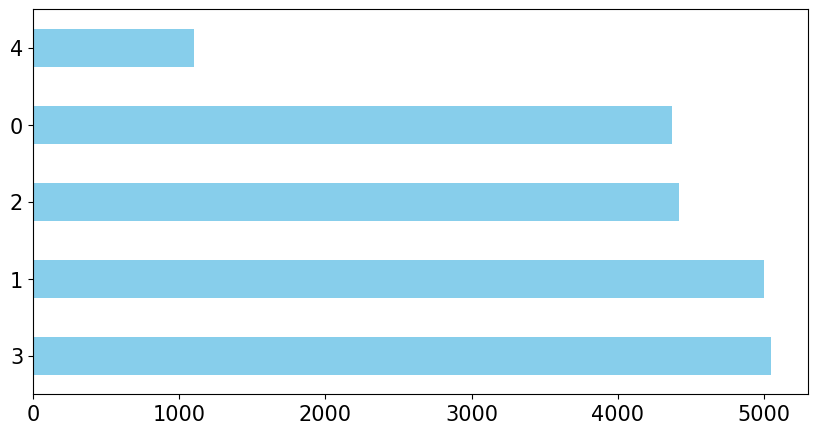

In [436]:
# Find out the avergage of longtitude and latitude for both train and test
if UJIInddorLoc_DF_train3['LONGITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_train3 = calculate_average(UJIInddorLoc_DF_train3,'long')

if UJIInddorLoc_DF_test3['LONGITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_test3 = calculate_average(UJIInddorLoc_DF_test3,'long')
    
if UJIInddorLoc_DF_train3['LATITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_train3 = calculate_average(UJIInddorLoc_DF_train3,'lat')
    
if UJIInddorLoc_DF_test3['LATITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_test3 = calculate_average(UJIInddorLoc_DF_test3,'lat')
    
print(UJIInddorLoc_DF_train3['LONGITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_test3['LONGITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_train3['LATITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_test3['LATITUDE'].head(5))

Original_DF_FLOOR3 = UJIInddorLoc_DF_train3['FLOOR'].value_counts()
Original_DF_FLOOR3.plot(kind='barh', figsize=(10,5), fontsize=15, color='skyblue')

# Evaluate Data
Training/validation set

In [437]:
print("Building 0",UJIInddorLoc_DF_train3.loc[UJIInddorLoc_DF_train3["BUILDINGID"] == 0]["FLOOR"].unique()) # building 0 has 4 floors
print("\nBuilding 1",UJIInddorLoc_DF_train3.loc[UJIInddorLoc_DF_train3["BUILDINGID"] == 1]["FLOOR"].unique()) # building 1 has 4 floors
print("\nBuilding 2",UJIInddorLoc_DF_train3.loc[UJIInddorLoc_DF_train3["BUILDINGID"] == 2]["FLOOR"].unique()) # building 2 has 5 floors
UJIInddorLoc_DF_train3.columns.values

Building 0 [1 2 3 0]

Building 1 [0 1 2 3]

Building 2 [4 1 3 2 0]


array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

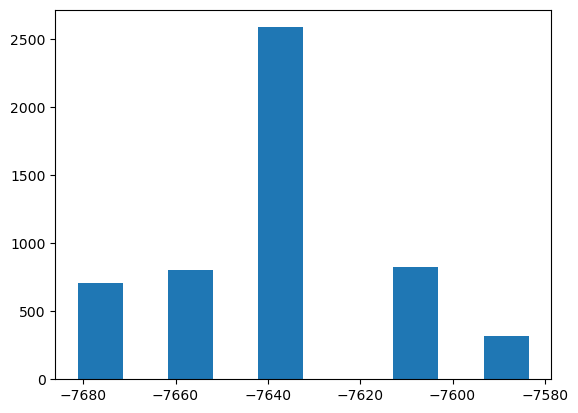

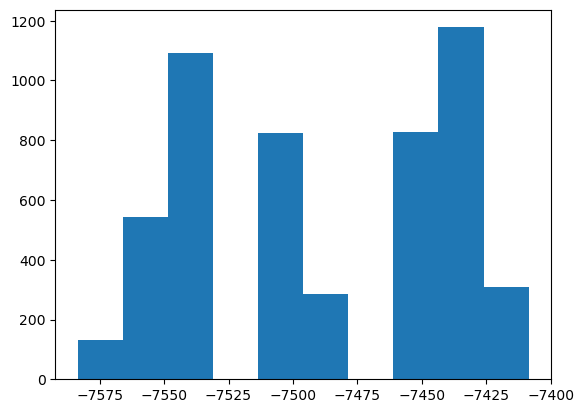

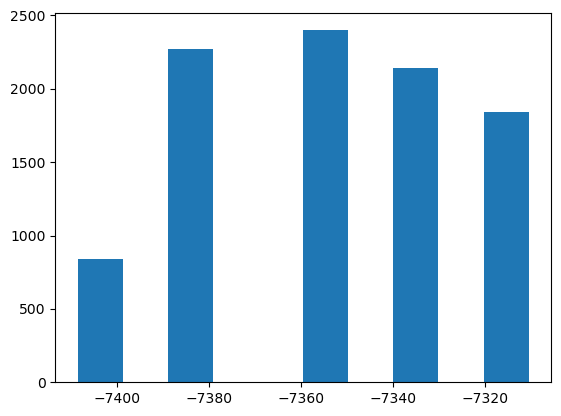

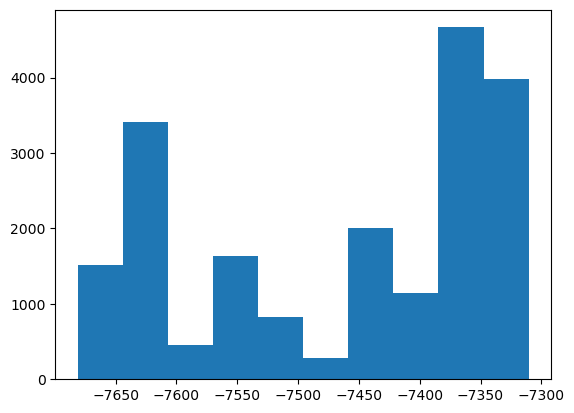

Missing Values: False


In [438]:
plt.hist(UJIInddorLoc_DF_train3.loc[UJIInddorLoc_DF_train3["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()
# Almost all fingerprints were collected right outside the door to each 
# fingerprint's SPACEID location.
# Building 0 fingerprints were collected by just 2 devices (and 2 separate 
# users). Not a lot of variety in different devices.

plt.hist(UJIInddorLoc_DF_train3.loc[UJIInddorLoc_DF_train3["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

plt.hist(UJIInddorLoc_DF_train3.loc[UJIInddorLoc_DF_train3["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

plt.hist(UJIInddorLoc_DF_train3["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.


# check for missing values
pd.isnull(UJIInddorLoc_DF_train3)
print("Missing Values:",pd.isnull(UJIInddorLoc_DF_train3).values.any())

Test set

In [439]:
print("Building 0",UJIInddorLoc_DF_test3.loc[UJIInddorLoc_DF_test3["BUILDINGID"] == 0]["FLOOR"].unique()) # building 0 has 4 floors
print("\nBuilding 1",UJIInddorLoc_DF_test3.loc[UJIInddorLoc_DF_test3["BUILDINGID"] == 1]["FLOOR"].unique()) # building 1 has 4 floors
print("\nBuilding 2",UJIInddorLoc_DF_test3.loc[UJIInddorLoc_DF_test3["BUILDINGID"] == 2]["FLOOR"].unique()) # building 2 has 5 floors
UJIInddorLoc_DF_test3.columns.values

Building 0 [0 1 2 3]

Building 1 [2 3 1 0]

Building 2 [1 0 3 2 4]


array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

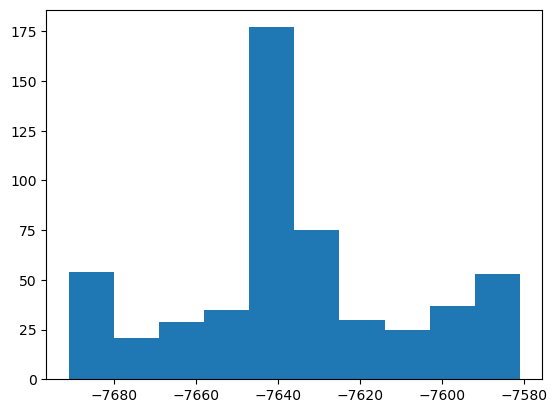

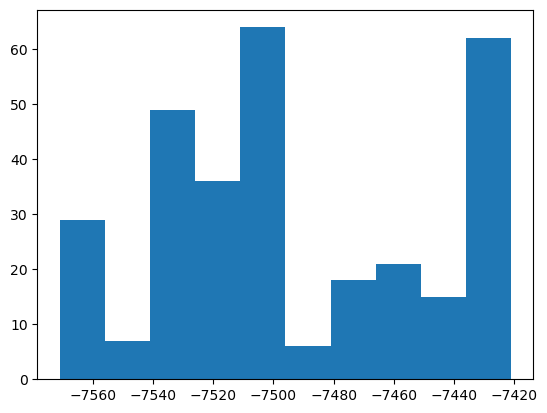

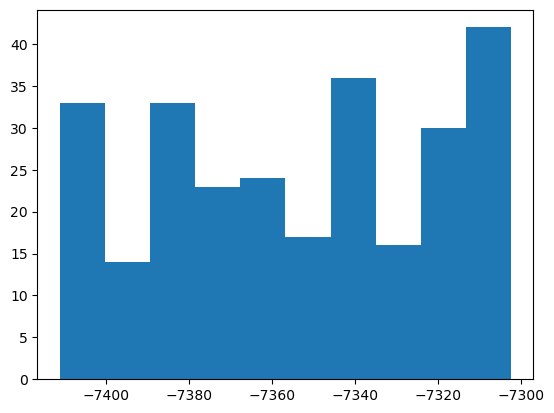

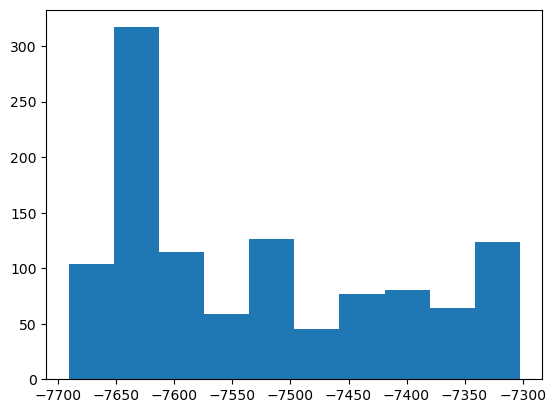

Missing Values: False


In [440]:
plt.hist(UJIInddorLoc_DF_test3.loc[UJIInddorLoc_DF_test3["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test3.loc[UJIInddorLoc_DF_test3["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test3.loc[UJIInddorLoc_DF_test3["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test3["LONGITUDE"])
plt.show()

# check for missing values
pd.isnull(UJIInddorLoc_DF_test3)
print("Missing Values:",pd.isnull(UJIInddorLoc_DF_test3).values.any())

# Preprocess Data and Feature Engineering
Training/validation Set

In [441]:
# Fingerprint data representation: positive-value representation for all WAPs.
# Original representation: -104 to 0 (weak to strong), 100 for no signal.
# New represenation: 1 to 105 (weak to strong), 0 for no signal.
UJIInddorLoc_DF_train3.iloc[:, 0:520].min().min() # minimum WAP is -104 dBm
train_set_P3 = UJIInddorLoc_DF_train3.copy()
train_set_P3.iloc[:, 0:520] = np.where(train_set_P3.iloc[:, 0:520] <= 0, 
                train_set_P3.iloc[:, 0:520] + 105, 
                train_set_P3.iloc[:, 0:520] - 100) 

# Feature Scaling - do not center - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

# Create a single label for the model to predict. FLOOR, LATITUDE, FLOOR, and 
# BUILDINGID pinpoints the exact location of a user inside a building. Stack 
# train set and test set first before assigning unique location so that 
# identical locations are assigned the same UNIQUELOCATION value.
combined3 = pd.concat([train_set_P3, UJIInddorLoc_DF_test3]) # stack vertically
combined3 = combined3.assign(UNIQUELOCATION = (combined3['LONGITUDE'].astype(str) + '_' + combined3['LATITUDE'].astype(str) + '_' + combined3['FLOOR'].astype(str) + '_' + combined3['BUILDINGID'].astype(str)).astype('category').cat.codes)
len(combined3["UNIQUELOCATION"].unique()) # 410 unique locations

468

In [442]:
# split again
train_set_PU3 = combined3.iloc[0:19937, :]
test_set_U3 = combined3.iloc[19937:21048, :]

# Change variable types
train_set_PU3["UNIQUELOCATION"] = train_set_PU3["UNIQUELOCATION"].astype("category")
print(train_set_PU3.dtypes)

X_train3 = train_set_PU3.iloc[:, 0:520]
y_train3 = train_set_PU3.iloc[:, 520:530]

WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object


/var/folders/31/mntbwvv97f9b6y8w30p020b00000gn/T/ipykernel_26549/3339593675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_PU3["UNIQUELOCATION"] = train_set_PU3["UNIQUELOCATION"].astype("category")


Test Set

In [443]:
# Fingerprint data representation
test_set_PU3 = test_set_U3.copy()
test_set_PU3.iloc[:, 0:520] = np.where(test_set_PU3.iloc[:, 0:520] <= 0, test_set_PU3.iloc[:, 0:520] + 105, test_set_PU3.iloc[:, 0:520] - 100) 

# Feature Scaling - do not center this data - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

test_set_PU3["UNIQUELOCATION"] = test_set_PU3["UNIQUELOCATION"].astype("category")
print(test_set_PU3.dtypes)

WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object


In [444]:
X_test3 = test_set_PU3.iloc[:, 0:520]
y_test3 = test_set_PU3.iloc[:, 520:530]

# Create a reference table for looking up the LONGITUDE, LATITUDE, FLOOR, and 
# BUILDINGID associated with each UNIQUELOCATION value.
ref_table3 = pd.concat([y_train3.iloc[:, [0,1,2,3,9]], y_test3.iloc[:, [0,1,2,3,9]]])
ref_table3 = ref_table3.drop_duplicates()

#save_data(X_train3, 'X_train_rf3.csv')
#save_data(y_train3, 'y_train_rf3.csv')
#save_data(X_test3, 'X_test_rf3.csv')
#save_data(y_test3, 'y_test_rf3.csv')

#--- load data ---#
#X_train3 = pd.read_csv('X_train_rf3.csv', index_col = 0)
#y_train3 = pd.read_csv('y_train_rf3.csv', index_col = 0)
#X_test3 = pd.read_csv('X_test_rf3.csv', index_col = 0)
#y_test3 = pd.read_csv('y_test_rf3.csv', index_col = 0)

#-- delete unneeded datasets created during preprocessing to free up memory --#
del UJIInddorLoc_DF_train3, train_set_P3, train_set_PU3, UJIInddorLoc_DF_test3, test_set_U3, test_set_PU3, combined3

# 3.1 RANDOM FOREST

In [445]:
file_exists = os.path.exists('Random_Forest_3_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = RandomForestClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters1,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result3 = grid.fit(X_train3, y_train3.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result3.best_estimator_)
    print(grid_result3.best_score_)
    print(grid_result3.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Random_Forest_3_1.json', 'w') as json_file:
        json.dump(grid_result3.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result3.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['RandomForestClassifier']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [446]:
read = open('Random_Forest_3_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
n_estimators = best[3]

start_train = time.time()
grid_result3 = RandomForestClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                n_estimators = n_estimators)

# Train the model
grid_result3.fit(X_train3, y_train3.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred3 = grid_result3.predict(X_test)
print("Mean:",np.mean(y_pred3 == y_test3.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos3 = y_test3.iloc[:, 0:2].values 
y_test_floor3 = y_test3.iloc[:, 2].values
y_test_building3 = y_test3.iloc[:, 3].values

dict_loc = {}
m_total = ref_table3.shape[0]
for i in range(m_total):
    key = int(ref_table3.iloc[i]['UNIQUELOCATION'])
    value = ref_table3.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 0:2] 
y_pred_floor3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 2]
y_pred_building3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 3]

# position errors for each test set example, in order as they appear
D_error3 = euclidean(y_test_pos3, y_pred_pos3)
# sorted   
sorted_D_error3 = sorted(D_error3)

m_test3 = y_test3.shape[0]
mean_error3 = np.mean(D_error3) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error3[math.ceil(m_test3*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error3[math.ceil(m_test3*0.50) - 1] # meters
percentile_75th = sorted_D_error3[math.ceil(m_test3*0.75) - 1] # meters
percentile_95th = sorted_D_error3[math.ceil(m_test3*0.95) - 1] # meters
percentile_100th = sorted_D_error3[math.ceil(m_test3*1.00) - 1] # meters
building_hitrate3 = np.mean(y_test_building3 == y_pred_building3)
floor_hitrate3 = np.mean(y_test_floor3 == y_pred_floor3)

mean_error_3_1 = np.mean(D_error3) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_3_1)
Random_Forest_Dict['Population Uniqueness'] = mean_error_3_1

Best Parameters Saved: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 60}
Mean: 0.0
Mean Error: 214.59284191624715


# 3.2 DECISION TREE

In [447]:
file_exists = os.path.exists('Decision_Tree_3_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = DecisionTreeClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters2,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result3 = grid.fit(X_train3, y_train3.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result3.best_estimator_)
    print(grid_result3.best_score_)
    print(grid_result3.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Decision_Tree_3_2.json', 'w') as json_file:
        json.dump(grid_result3.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result3.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['DecisionTree']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [448]:
read = open('Decision_Tree_3_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
grid_result3 = DecisionTreeClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
grid_result3.fit(X_train3, y_train3.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred3 = grid_result3.predict(X_test3)
print("Mean:",np.mean(y_pred3 == y_test3.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos3 = y_test3.iloc[:, 0:2].values 
y_test_floor3 = y_test3.iloc[:, 2].values
y_test_building3 = y_test3.iloc[:, 3].values

dict_loc = {}
m_total = ref_table3.shape[0]
for i in range(m_total):
    key = int(ref_table3.iloc[i]['UNIQUELOCATION'])
    value = ref_table3.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 0:2] 
y_pred_floor3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 2]
y_pred_building3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 3]

# position errors for each test set example, in order as they appear
D_error3 = euclidean(y_test_pos3, y_pred_pos3)
# sorted   
sorted_D_error3 = sorted(D_error3)

m_test3 = y_test3.shape[0]
mean_error3 = np.mean(D_error3) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error3[math.ceil(m_test3*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error3[math.ceil(m_test3*0.50) - 1] # meters
percentile_75th = sorted_D_error3[math.ceil(m_test3*0.75) - 1] # meters
percentile_95th = sorted_D_error3[math.ceil(m_test3*0.95) - 1] # meters
percentile_100th = sorted_D_error3[math.ceil(m_test3*1.00) - 1] # meters
building_hitrate3 = np.mean(y_test_building3 == y_pred_building3)
floor_hitrate3 = np.mean(y_test_floor3 == y_pred_floor3)

mean_error_3_3 = np.mean(D_error3) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_3_3)
Decision_Tree_Dict['Population Uniqueness'] = mean_error_3_3

Best Parameters Saved: {'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 60, 'random_state': 42, 'splitter': 'best'}
Mean: 0.0
Mean Error: 32.23560832742209


# 3.3 KNN

In [449]:
file_exists = os.path.exists('KNN_3_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = KNeighborsClassifier()

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters3,
                        scoring = scoring,
                        cv = 2, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result3 = grid.fit(X_train3, y_train3.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result3.best_estimator_)
    print(grid_result3.best_score_)
    print(grid_result3.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('KNN_3_3.json', 'w') as json_file:
        json.dump(grid_result3.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result3.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['KNN']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [450]:
read = open('KNN_3_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
grid_result3 = KNeighborsClassifier(algorithm = algorithm,  leaf_size = leaf_size, metric = metric, \
                                n_neighbors = n_neighbors, p = p, weights = weights)

# Train the model
grid_result3.fit(X_train3, y_train3.iloc[:, 9].squeeze())



#--- test set metrics ---#
y_pred3 = grid_result3.predict(X_test3)
print("Mean:",np.mean(y_pred3 == y_test3.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos3 = y_test3.iloc[:, 0:2].values 
y_test_floor3 = y_test3.iloc[:, 2].values
y_test_building3 = y_test3.iloc[:, 3].values

dict_loc = {}
m_total = ref_table3.shape[0]
for i in range(m_total):
    key = int(ref_table3.iloc[i]['UNIQUELOCATION'])
    value = ref_table3.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 0:2] 
y_pred_floor3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 2]
y_pred_building3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 3]

# position errors for each test set example, in order as they appear
D_error3 = euclidean(y_test_pos3, y_pred_pos3)
# sorted   
sorted_D_error3 = sorted(D_error3)

m_test3 = y_test3.shape[0]
mean_error3 = np.mean(D_error3) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error3[math.ceil(m_test3*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error3[math.ceil(m_test3*0.50) - 1] # meters
percentile_75th = sorted_D_error3[math.ceil(m_test3*0.75) - 1] # meters
percentile_95th = sorted_D_error3[math.ceil(m_test3*0.95) - 1] # meters
percentile_100th = sorted_D_error3[math.ceil(m_test3*1.00) - 1] # meters
building_hitrate3 = np.mean(y_test_building3 == y_pred_building3)
floor_hitrate3 = np.mean(y_test_floor3 == y_pred_floor3)

mean_error_3_3 = np.mean(D_error3) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_3_3)
KNN_Dict['Population Uniqueness'] = mean_error_3_3

Best Parameters Saved: {'algorithm': 'brute', 'leaf_size': 5, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Mean: 0.0
Mean Error: 17.07323306980266


# 3.4 EXTRA TREE

In [451]:
file_exists = os.path.exists('Extra_Tree_3_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = ExtraTreeClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters4,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result3 = grid.fit(X_train3, y_train3.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result3.best_estimator_)
    print(grid_result3.best_score_)
    print(grid_result3.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Extra_Tree_3_4.json', 'w') as json_file:
        json.dump(grid_result3.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result3.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['ExtraTree']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [452]:
read = open('Extra_Tree_2_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
grid_result3 = ExtraTreeClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
grid_result3.fit(X_train3, y_train3.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred3 = grid_result3.predict(X_test3)
print("Mean:",np.mean(y_pred3 == y_test3.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos3 = y_test3.iloc[:, 0:2].values 
y_test_floor3 = y_test3.iloc[:, 2].values
y_test_building3 = y_test3.iloc[:, 3].values

dict_loc = {}
m_total = ref_table3.shape[0]
for i in range(m_total):
    key = int(ref_table3.iloc[i]['UNIQUELOCATION'])
    value = ref_table3.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 0:2] 
y_pred_floor3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 2]
y_pred_building3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 3]

# position errors for each test set example, in order as they appear
D_error3 = euclidean(y_test_pos3, y_pred_pos3)
# sorted   
sorted_D_error3 = sorted(D_error3)

m_test3 = y_test3.shape[0]
mean_error3 = np.mean(D_error3) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error3[math.ceil(m_test3*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error3[math.ceil(m_test3*0.50) - 1] # meters
percentile_75th = sorted_D_error3[math.ceil(m_test3*0.75) - 1] # meters
percentile_95th = sorted_D_error3[math.ceil(m_test3*0.95) - 1] # meters
percentile_100th = sorted_D_error3[math.ceil(m_test3*1.00) - 1] # meters
building_hitrate3 = np.mean(y_test_building3 == y_pred_building3)
floor_hitrate3 = np.mean(y_test_floor3 == y_pred_floor3)

mean_error_3_4 = np.mean(D_error3) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_3_4)
Extra_Tree_Dict['Population Uniqueness'] = mean_error_3_4

Best Parameters Saved: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 20, 'random_state': 42, 'splitter': 'best'}
Mean: 0.0
Mean Error: 21.589957145073285


# 3.5 VOTING

In [453]:
file_exists = os.path.exists('Voting_3_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)])

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters5,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result3 = grid.fit(X_train3, y_train3.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result3.best_estimator_)
    print(grid_result3.best_score_)
    print(grid_result3.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Voting_3_5.json', 'w') as json_file:
        json.dump(grid_result3.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result3.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['Voting']*cv_results_.shape[0])
#     cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
#                        value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
#     cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
#                        value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
#     with open('tuning_rf.csv', 'a') as f:
    cv_results_.to_csv(f, header = True)

File exists: True


In [454]:
read = open('Voting_3_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
voting = best[0]

start_train = time.time()
grid_result3 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting = voting)

# Train the model
grid_result3.fit(X_train3, y_train3.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred3 = grid_result3.predict(X_test3)
print("Mean:",np.mean(y_pred3 == y_test3.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos3 = y_test3.iloc[:, 0:2].values 
y_test_floor3 = y_test3.iloc[:, 2].values
y_test_building3 = y_test3.iloc[:, 3].values

dict_loc = {}
m_total = ref_table3.shape[0]
for i in range(m_total):
    key = int(ref_table3.iloc[i]['UNIQUELOCATION'])
    value = ref_table3.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 0:2] 
y_pred_floor3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 2]
y_pred_building3 = np.asarray([dict_loc[i] for i in y_pred3])[:, 3]

# position errors for each test set example, in order as they appear
D_error3 = euclidean(y_test_pos3, y_pred_pos3)
# sorted   
sorted_D_error3 = sorted(D_error3)

m_test3 = y_test3.shape[0]
mean_error3 = np.mean(D_error3) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error3[math.ceil(m_test3*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error3[math.ceil(m_test3*0.50) - 1] # meters
percentile_75th = sorted_D_error3[math.ceil(m_test3*0.75) - 1] # meters
percentile_95th = sorted_D_error3[math.ceil(m_test3*0.95) - 1] # meters
percentile_100th = sorted_D_error3[math.ceil(m_test3*1.00) - 1] # meters
building_hitrate3 = np.mean(y_test_building3 == y_pred_building3)
floor_hitrate3 = np.mean(y_test_floor3 == y_pred_floor3)

mean_error_3_5 = np.mean(D_error3) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_3_5)
Voting_Dict['Population Uniqueness'] = mean_error_3_5

Best Parameters Saved: {'voting': 'hard'}


/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean: 0.0
Mean Error: 12.456472770300431


# 4. Import Anonymized Dataset using Average Re-identification Risk

In [504]:
# 3rd anonymized dataset
UJIInddorLoc_DF_train4 = pd.read_csv('Optimum_Train_Average-reidentification-risk_1_1.csv')
UJIInddorLoc_DF_test4 = pd.read_csv('Optimum_Test_Average-reidentification-risk_1_1.csv')

print(UJIInddorLoc_DF_train4.shape,UJIInddorLoc_DF_test4.shape)

(19937, 529) (1111, 529)


In [505]:
UJIInddorLoc_DF_train4

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864790, 4864805[",2,2,139,1,11,13,1371723107
1,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864790, 4864805[",2,2,139,1,11,13,1371723145
2,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864790, 4864805[",2,2,139,1,11,13,1371723120
3,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864790, 4864805[",2,2,139,1,11,13,1371723095
4,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864790, 4864805[",2,2,139,1,11,13,1371723111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7676[","[4864925, 4864940[",3,0,223,2,1,14,1371056143
19933,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7676[","[4864925, 4864940[",1,0,222,2,1,14,1371049002
19934,100,100,100,100,100,100,100,100,-89,100,...,100,"[-7691.338, -7676[","[4864925, 4864940[",2,0,224,2,1,14,1371051598
19935,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7676[","[4864925, 4864940[",3,0,223,2,1,14,1371056145


In [506]:
print(UJIInddorLoc_DF_train4['LONGITUDE'].head(5))
print("\n",UJIInddorLoc_DF_train4['LATITUDE'].head(5))
print("\n",UJIInddorLoc_DF_test4['LONGITUDE'].head(5))
print("\n",UJIInddorLoc_DF_test4['LATITUDE'].head(5))
UJIInddorLoc_DF_train4.describe()

0    [-7316, -7299.819[
1    [-7316, -7299.819[
2    [-7316, -7299.819[
3    [-7316, -7299.819[
4    [-7316, -7299.819[
Name: LONGITUDE, dtype: object

 0    [4864790, 4864805[
1    [4864790, 4864805[
2    [4864790, 4864805[
3    [4864790, 4864805[
4    [4864790, 4864805[
Name: LATITUDE, dtype: object

 0    [-7316, -7298.787[
1    [-7316, -7298.787[
2    [-7316, -7298.787[
3    [-7316, -7298.787[
4    [-7316, -7298.787[
Name: LONGITUDE, dtype: object

 0    [4864785, 4864805[
1    [4864785, 4864805[
2    [4864785, 4864805[
3    [4864785, 4864805[
4    [4864785, 4864805[
Name: LATITUDE, dtype: object


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP518,WAP519,WAP520,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.000000,19937.000000,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,99.823644,99.820936,100.0,100.0,99.613733,97.130461,94.733661,93.820234,94.693936,99.163766,...,99.788634,99.970507,100.0,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,5.866842,5.798156,0.0,0.0,8.615657,22.931890,30.541335,33.010404,30.305084,12.634045,...,6.360671,2.404232,0.0,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,...,-97.000000,-97.000000,100.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


0   -7307.91
1   -7307.91
2   -7307.91
3   -7307.91
4   -7307.91
Name: LONGITUDE, dtype: float64 

0   -7307.394
1   -7307.394
2   -7307.394
3   -7307.394
4   -7307.394
Name: LONGITUDE, dtype: float64 

0    4864797.45
1    4864797.45
2    4864797.45
3    4864797.45
4    4864797.45
Name: LATITUDE, dtype: float64 

0    4864794.95
1    4864794.95
2    4864794.95
3    4864794.95
4    4864794.95
Name: LATITUDE, dtype: float64


<AxesSubplot:>

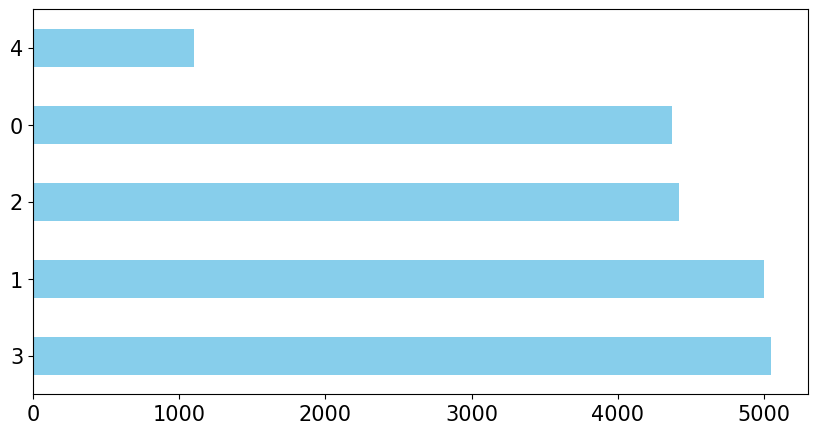

In [507]:
# Find out the avergage of longtitude and latitude for both train and test
if UJIInddorLoc_DF_train4['LONGITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_train4 = calculate_average(UJIInddorLoc_DF_train4,'long')

if UJIInddorLoc_DF_test4['LONGITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_test4 = calculate_average(UJIInddorLoc_DF_test4,'long')
    
if UJIInddorLoc_DF_train4['LATITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_train4 = calculate_average(UJIInddorLoc_DF_train4,'lat')
    
if UJIInddorLoc_DF_test4['LATITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_test4 = calculate_average(UJIInddorLoc_DF_test4,'lat')
    
print(UJIInddorLoc_DF_train4['LONGITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_test4['LONGITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_train4['LATITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_test4['LATITUDE'].head(5))

Original_DF_FLOOR4 = UJIInddorLoc_DF_train4['FLOOR'].value_counts()
Original_DF_FLOOR4.plot(kind='barh', figsize=(10,5), fontsize=15, color='skyblue')

# Evaluate Data
Training/validation set

In [508]:
print("Building 0",UJIInddorLoc_DF_train4.loc[UJIInddorLoc_DF_train4["BUILDINGID"] == 0]["FLOOR"].unique()) # building 0 has 4 floors
print("\nBuilding 1",UJIInddorLoc_DF_train4.loc[UJIInddorLoc_DF_train4["BUILDINGID"] == 1]["FLOOR"].unique()) # building 1 has 4 floors
print("\nBuilding 2",UJIInddorLoc_DF_train4.loc[UJIInddorLoc_DF_train4["BUILDINGID"] == 2]["FLOOR"].unique()) # building 2 has 5 floors
UJIInddorLoc_DF_train4.columns.values

Building 0 [1 2 3 0]

Building 1 [2 1 0 3]

Building 2 [2 4 1 3 0]


array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

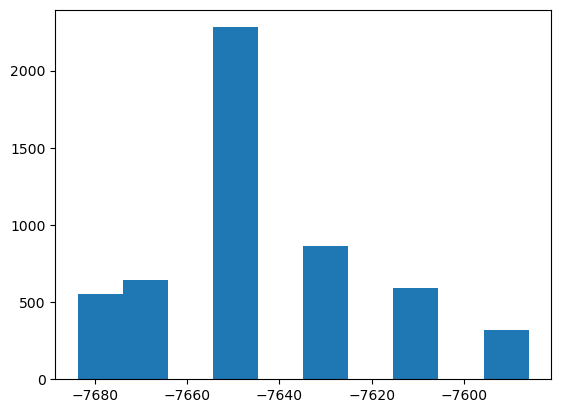

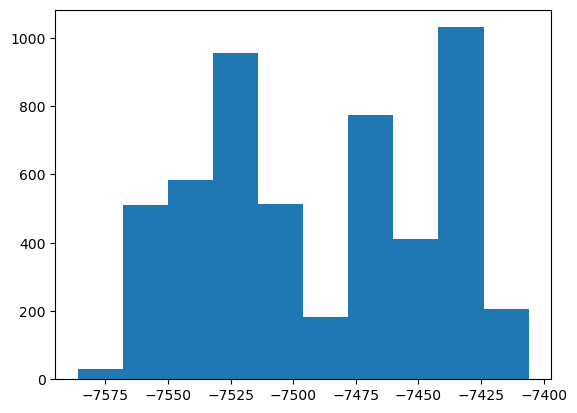

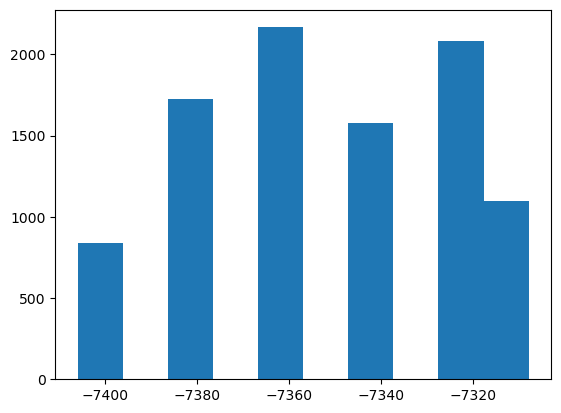

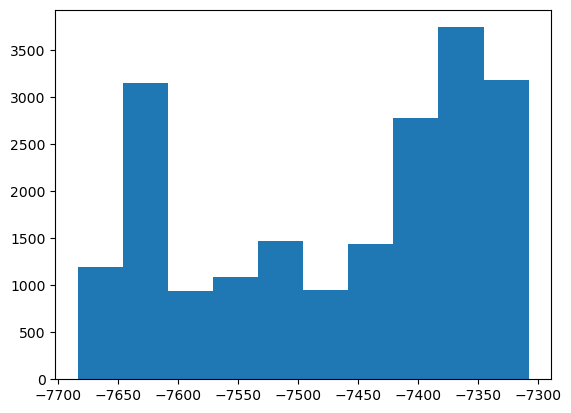

Missing Values: False


In [509]:
plt.hist(UJIInddorLoc_DF_train4.loc[UJIInddorLoc_DF_train4["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()
# Almost all fingerprints were collected right outside the door to each 
# fingerprint's SPACEID location.
# Building 0 fingerprints were collected by just 2 devices (and 2 separate 
# users). Not a lot of variety in different devices.

plt.hist(UJIInddorLoc_DF_train4.loc[UJIInddorLoc_DF_train4["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

plt.hist(UJIInddorLoc_DF_train4.loc[UJIInddorLoc_DF_train4["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

plt.hist(UJIInddorLoc_DF_train4["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.


# check for missing values
pd.isnull(UJIInddorLoc_DF_train4)
print("Missing Values:",pd.isnull(UJIInddorLoc_DF_train4).values.any())

Test set

In [510]:
print("Building 0",UJIInddorLoc_DF_test4.loc[UJIInddorLoc_DF_test4["BUILDINGID"] == 0]["FLOOR"].unique()) # building 0 has 4 floors
print("\nBuilding 1",UJIInddorLoc_DF_test4.loc[UJIInddorLoc_DF_test4["BUILDINGID"] == 1]["FLOOR"].unique()) # building 1 has 4 floors
print("\nBuilding 2",UJIInddorLoc_DF_test4.loc[UJIInddorLoc_DF_test4["BUILDINGID"] == 2]["FLOOR"].unique()) # building 2 has 5 floors
UJIInddorLoc_DF_test4.columns.values

Building 0 [0 1 2 3]

Building 1 [3 2 0 1]

Building 2 [1 0 3 2 4]


array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

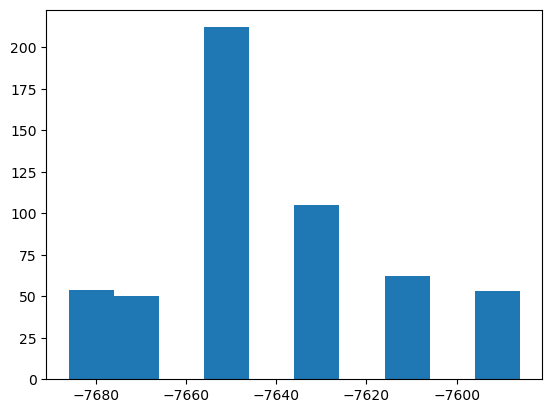

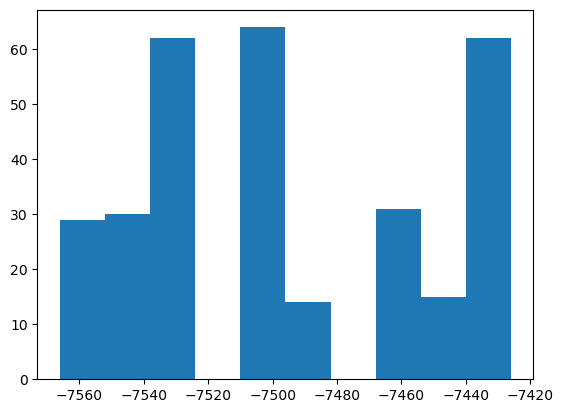

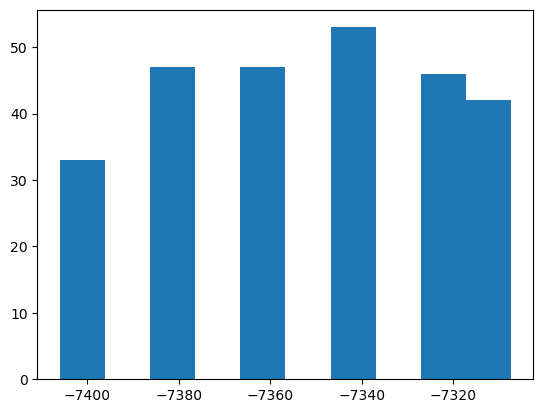

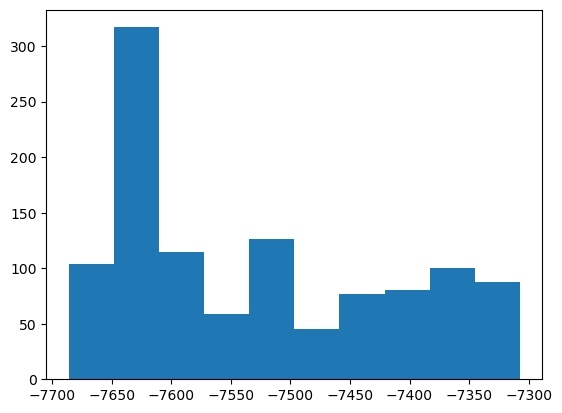

Missing Values: False


In [511]:
plt.hist(UJIInddorLoc_DF_test4.loc[UJIInddorLoc_DF_test4["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test4.loc[UJIInddorLoc_DF_test4["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test4.loc[UJIInddorLoc_DF_test4["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test4["LONGITUDE"])
plt.show()

# check for missing values
pd.isnull(UJIInddorLoc_DF_test4)
print("Missing Values:",pd.isnull(UJIInddorLoc_DF_test4).values.any())

# Preprocess Data and Feature Engineering
Training/validation Set

In [512]:
# Fingerprint data representation: positive-value representation for all WAPs.
# Original representation: -104 to 0 (weak to strong), 100 for no signal.
# New represenation: 1 to 105 (weak to strong), 0 for no signal.
UJIInddorLoc_DF_train4.iloc[:, 0:520].min().min() # minimum WAP is -104 dBm
train_set_P4 = UJIInddorLoc_DF_train4.copy()
train_set_P4.iloc[:, 0:520] = np.where(train_set_P4.iloc[:, 0:520] <= 0, 
                train_set_P4.iloc[:, 0:520] + 105, 
                train_set_P4.iloc[:, 0:520] - 100) 

# Feature Scaling - do not center - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

# Create a single label for the model to predict. FLOOR, LATITUDE, FLOOR, and 
# BUILDINGID pinpoints the exact location of a user inside a building. Stack 
# train set and test set first before assigning unique location so that 
# identical locations are assigned the same UNIQUELOCATION value.
combined4 = pd.concat([train_set_P4, UJIInddorLoc_DF_test4]) # stack vertically
combined4 = combined4.assign(UNIQUELOCATION = (combined4['LONGITUDE'].astype(str) + '_' + combined4['LATITUDE'].astype(str) + '_' + combined4['FLOOR'].astype(str) + '_' + combined4['BUILDINGID'].astype(str)).astype('category').cat.codes)
len(combined4["UNIQUELOCATION"].unique()) # 288 unique locations

495

In [513]:
# split again
train_set_PU4 = combined4.iloc[0:19937, :]
test_set_U4 = combined4.iloc[19937:21048, :]

# Change variable types
train_set_PU4["UNIQUELOCATION"] = train_set_PU4["UNIQUELOCATION"].astype("category")
print(train_set_PU4.dtypes)

X_train4 = train_set_PU4.iloc[:, 0:520]
y_train4 = train_set_PU4.iloc[:, 520:530]

WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object


/var/folders/31/mntbwvv97f9b6y8w30p020b00000gn/T/ipykernel_26549/3105342933.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_PU4["UNIQUELOCATION"] = train_set_PU4["UNIQUELOCATION"].astype("category")


Test Set

In [514]:
# Fingerprint data representation
test_set_PU4 = test_set_U4.copy()
test_set_PU4.iloc[:, 0:520] = np.where(test_set_PU4.iloc[:, 0:520] <= 0, test_set_PU4.iloc[:, 0:520] + 105, test_set_PU4.iloc[:, 0:520] - 100) 

# Feature Scaling - do not center this data - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

test_set_PU4["UNIQUELOCATION"] = test_set_PU4["UNIQUELOCATION"].astype("category")
print(test_set_PU4.dtypes)

WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object


In [515]:
X_test4 = test_set_PU4.iloc[:, 0:520]
y_test4 = test_set_PU4.iloc[:, 520:530]

# Create a reference table for looking up the LONGITUDE, LATITUDE, FLOOR, and 
# BUILDINGID associated with each UNIQUELOCATION value.
ref_table4 = pd.concat([y_train4.iloc[:, [0,1,2,3,9]], y_test4.iloc[:, [0,1,2,3,9]]])
ref_table4 = ref_table4.drop_duplicates()

#save_data(X_train4, 'X_train_rf4.csv')
#save_data(y_train4, 'y_train_rf4.csv')
#save_data(X_test4, 'X_test_rf4.csv')
#save_data(y_test4, 'y_test_rf4.csv')

#--- load data ---#
#X_train4 = pd.read_csv('X_train_rf4.csv', index_col = 0)
#y_train4 = pd.read_csv('y_train_rf4.csv', index_col = 0)
#X_test4 = pd.read_csv('X_test_rf4.csv', index_col = 0)
#y_test4 = pd.read_csv('y_test_rf4.csv', index_col = 0)

#-- delete unneeded datasets created during preprocessing to free up memory --#
del UJIInddorLoc_DF_train4, train_set_P4, train_set_PU4, UJIInddorLoc_DF_test4, test_set_U4, test_set_PU4, combined4

# 4.1 RANDOM FOREST

In [516]:
file_exists = os.path.exists('Random_Forest_4_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = RandomForestClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters1,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result4 = grid.fit(X_train4, y_train4.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result4.best_estimator_)
    print(grid_result4.best_score_)
    print(grid_result4.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Random_Forest_4_1.json', 'w') as json_file:
        json.dump(grid_result4.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result4.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['RandomForestClassifier']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [517]:
read = open('Random_Forest_4_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
n_estimators = best[3]

start_train = time.time()
grid_result4 = RandomForestClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                n_estimators = n_estimators)

# Train the model
grid_result4.fit(X_train4, y_train4.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred4 = grid_result4.predict(X_test4)
print("Mean:",np.mean(y_pred4 == y_test4.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos4 = y_test4.iloc[:, 0:2].values 
y_test_floor4 = y_test4.iloc[:, 2].values
y_test_building4 = y_test4.iloc[:, 3].values

dict_loc = {}
m_total = ref_table4.shape[0]
for i in range(m_total):
    key = int(ref_table4.iloc[i]['UNIQUELOCATION'])
    value = ref_table4.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 0:2] 
y_pred_floor4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 2]
y_pred_building4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 3]

# position errors for each test set example, in order as they appear
D_error4 = euclidean(y_test_pos4, y_pred_pos4)
# sorted   
sorted_D_error4 = sorted(D_error4)

m_test4 = y_test4.shape[0]
mean_error4 = np.mean(D_error4) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error4[math.ceil(m_test4*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error4[math.ceil(m_test4*0.50) - 1] # meters
percentile_75th = sorted_D_error4[math.ceil(m_test4*0.75) - 1] # meters
percentile_95th = sorted_D_error4[math.ceil(m_test4*0.95) - 1] # meters
percentile_100th = sorted_D_error4[math.ceil(m_test4*1.00) - 1] # meters
building_hitrate4 = np.mean(y_test_building4 == y_pred_building4)
floor_hitrate4 = np.mean(y_test_floor4 == y_pred_floor4)

mean_error_4_1 = np.mean(D_error4) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_4_1)
Random_Forest_Dict['Avg Re-identification Risk'] = mean_error_4_1

Best Parameters Saved: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 60}
Mean: 0.0
Mean Error: 11.431867425609223


# 4.2 DECISION TREE

In [518]:
file_exists = os.path.exists('Decision_Tree_4_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = DecisionTreeClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters2,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result4 = grid.fit(X_train4, y_train4.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result4.best_estimator_)
    print(grid_result4.best_score_)
    print(grid_result4.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Decision_Tree_4_2.json', 'w') as json_file:
        json.dump(grid_result4.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result4.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['DecisionTree']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [519]:
read = open('Decision_Tree_4_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
grid_result4 = DecisionTreeClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
grid_result4.fit(X_train4, y_train4.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred4 = grid_result4.predict(X_test4)
print("Mean:",np.mean(y_pred4 == y_test4.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos4 = y_test4.iloc[:, 0:2].values 
y_test_floor4 = y_test4.iloc[:, 2].values
y_test_building4 = y_test4.iloc[:, 3].values

dict_loc = {}
m_total = ref_table4.shape[0]
for i in range(m_total):
    key = int(ref_table4.iloc[i]['UNIQUELOCATION'])
    value = ref_table4.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 0:2] 
y_pred_floor4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 2]
y_pred_building4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 3]

# position errors for each test set example, in order as they appear
D_error4 = euclidean(y_test_pos4, y_pred_pos4)
# sorted   
sorted_D_error4 = sorted(D_error4)

m_test4 = y_test4.shape[0]
mean_error4 = np.mean(D_error4) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error4[math.ceil(m_test4*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error4[math.ceil(m_test4*0.50) - 1] # meters
percentile_75th = sorted_D_error4[math.ceil(m_test4*0.75) - 1] # meters
percentile_95th = sorted_D_error4[math.ceil(m_test4*0.95) - 1] # meters
percentile_100th = sorted_D_error4[math.ceil(m_test4*1.00) - 1] # meters
building_hitrate4 = np.mean(y_test_building4 == y_pred_building4)
floor_hitrate4 = np.mean(y_test_floor4 == y_pred_floor4)

mean_error_4_2 = np.mean(D_error4) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_4_2)
Decision_Tree_Dict['Avg Re-identification Risk'] = mean_error_4_2

Best Parameters Saved: {'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 60, 'random_state': 42, 'splitter': 'best'}
Mean: 0.0
Mean Error: 29.863062156979773


# 4.3 KNN

In [520]:
file_exists = os.path.exists('KNN_4_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = KNeighborsClassifier()

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters3,
                        scoring = scoring,
                        cv = 2, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result4 = grid.fit(X_train4, y_train4.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result4.best_estimator_)
    print(grid_result4.best_score_)
    print(grid_result4.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('KNN_4_3.json', 'w') as json_file:
        json.dump(grid_result4.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result4.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['KNN']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [521]:
read = open('KNN_4_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
grid_result4 = KNeighborsClassifier(algorithm = algorithm,  leaf_size = leaf_size, metric = metric, \
                                n_neighbors = n_neighbors, p = p, weights = weights)

# Train the model
grid_result4.fit(X_train4, y_train4.iloc[:, 9].squeeze())


#--- test set metrics ---#
y_pred4 = grid_result4.predict(X_test4)
print("Mean:",np.mean(y_pred4 == y_test4.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos4 = y_test4.iloc[:, 0:2].values 
y_test_floor4 = y_test4.iloc[:, 2].values
y_test_building4 = y_test4.iloc[:, 3].values

dict_loc = {}
m_total = ref_table4.shape[0]
for i in range(m_total):
    key = int(ref_table4.iloc[i]['UNIQUELOCATION'])
    value = ref_table4.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 0:2] 
y_pred_floor4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 2]
y_pred_building4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 3]

# position errors for each test set example, in order as they appear
D_error4 = euclidean(y_test_pos4, y_pred_pos4)
# sorted   
sorted_D_error4 = sorted(D_error4)

m_test4 = y_test4.shape[0]
mean_error4 = np.mean(D_error4) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error4[math.ceil(m_test4*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error4[math.ceil(m_test4*0.50) - 1] # meters
percentile_75th = sorted_D_error4[math.ceil(m_test4*0.75) - 1] # meters
percentile_95th = sorted_D_error4[math.ceil(m_test4*0.95) - 1] # meters
percentile_100th = sorted_D_error4[math.ceil(m_test4*1.00) - 1] # meters
building_hitrate4 = np.mean(y_test_building4 == y_pred_building4)
floor_hitrate4 = np.mean(y_test_floor4 == y_pred_floor4)

mean_error_4_3 = np.mean(D_error4) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_4_3)
KNN_Dict['Avg Re-identification Risk'] = mean_error_4_3

Best Parameters Saved: {'algorithm': 'kd_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
Mean: 0.0
Mean Error: 14.203145319120477


# 4.4 EXTRA TREE

In [522]:
file_exists = os.path.exists('Extra_Tree_4_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = ExtraTreeClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters4,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result4 = grid.fit(X_train4, y_train4.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result4.best_estimator_)
    print(grid_result4.best_score_)
    print(grid_result4.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Extra_Tree_4_4.json', 'w') as json_file:
        json.dump(grid_result4.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result4.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['ExtraTree']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [523]:
read = open('Extra_Tree_2_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
grid_result4 = ExtraTreeClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
grid_result4.fit(X_train4, y_train4.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred4 = grid_result4.predict(X_test4)
print("Mean:",np.mean(y_pred4 == y_test4.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos4 = y_test4.iloc[:, 0:2].values 
y_test_floor4 = y_test4.iloc[:, 2].values
y_test_building4 = y_test4.iloc[:, 3].values

dict_loc = {}
m_total = ref_table4.shape[0]
for i in range(m_total):
    key = int(ref_table4.iloc[i]['UNIQUELOCATION'])
    value = ref_table4.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 0:2] 
y_pred_floor4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 2]
y_pred_building4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 3]

# position errors for each test set example, in order as they appear
D_error4 = euclidean(y_test_pos4, y_pred_pos4)
# sorted   
sorted_D_error4 = sorted(D_error4)

m_test4 = y_test4.shape[0]
mean_error4 = np.mean(D_error4) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error4[math.ceil(m_test4*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error4[math.ceil(m_test4*0.50) - 1] # meters
percentile_75th = sorted_D_error4[math.ceil(m_test4*0.75) - 1] # meters
percentile_95th = sorted_D_error4[math.ceil(m_test4*0.95) - 1] # meters
percentile_100th = sorted_D_error4[math.ceil(m_test4*1.00) - 1] # meters
building_hitrate4 = np.mean(y_test_building4 == y_pred_building4)
floor_hitrate4 = np.mean(y_test_floor4 == y_pred_floor4)

mean_error_4_4 = np.mean(D_error4) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_4_4)
Extra_Tree_Dict['Avg Re-identification Risk'] = mean_error_4_4

Best Parameters Saved: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 20, 'random_state': 42, 'splitter': 'best'}
Mean: 0.0
Mean Error: 21.478526787693948


# 4.5 VOTING

In [524]:
file_exists = os.path.exists('Voting_4_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)])

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters5,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result4 = grid.fit(X_train4, y_train4.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result4.best_estimator_)
    print(grid_result4.best_score_)
    print(grid_result4.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Voting_4_5.json', 'w') as json_file:
        json.dump(grid_result4.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result4.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['Voting']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [525]:
read = open('Voting_3_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
voting = best[0]

start_train = time.time()
grid_result4 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting = voting)

# Train the model
grid_result4.fit(X_train4, y_train4.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred4 = grid_result4.predict(X_test4)
print("Mean:",np.mean(y_pred4 == y_test4.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos4 = y_test4.iloc[:, 0:2].values 
y_test_floor4 = y_test4.iloc[:, 2].values
y_test_building4 = y_test4.iloc[:, 3].values

dict_loc = {}
m_total = ref_table4.shape[0]
for i in range(m_total):
    key = int(ref_table4.iloc[i]['UNIQUELOCATION'])
    value = ref_table4.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 0:2] 
y_pred_floor4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 2]
y_pred_building4 = np.asarray([dict_loc[i] for i in y_pred4])[:, 3]

# position errors for each test set example, in order as they appear
D_error4 = euclidean(y_test_pos4, y_pred_pos4)
# sorted   
sorted_D_error4 = sorted(D_error4)

m_test4 = y_test4.shape[0]
mean_error4 = np.mean(D_error4) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error4[math.ceil(m_test4*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error4[math.ceil(m_test4*0.50) - 1] # meters
percentile_75th = sorted_D_error4[math.ceil(m_test4*0.75) - 1] # meters
percentile_95th = sorted_D_error4[math.ceil(m_test4*0.95) - 1] # meters
percentile_100th = sorted_D_error4[math.ceil(m_test4*1.00) - 1] # meters
building_hitrate4 = np.mean(y_test_building4 == y_pred_building4)
floor_hitrate4 = np.mean(y_test_floor4 == y_pred_floor4)

mean_error_4_5 = np.mean(D_error4) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_4_5)
Voting_Dict['Avg Re-identification Risk'] = mean_error_4_5

Best Parameters Saved: {'voting': 'hard'}


/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean: 0.0
Mean Error: 12.129120764205966


# 5. Import Anonymized Dataset using Differential Privacy

In [590]:
# Original Dataset
UJIInddorLoc_DF_train5 = pd.read_csv('Optimum_Train_Differential_Privacy_2_2.csv')
UJIInddorLoc_DF_test5 = pd.read_csv('Optimum_Test_Differential_Privacy_2_2.csv')

print(UJIInddorLoc_DF_train5.shape,UJIInddorLoc_DF_test5.shape)

(18325, 529) (835, 529)


In [591]:
# Drop rows with * in LONGITUDE or LATITUDE
getTrainIndex = UJIInddorLoc_DF_train5[(UJIInddorLoc_DF_train5['LONGITUDE']=='*') | (UJIInddorLoc_DF_train5['LATITUDE']=='*')].index
UJIInddorLoc_DF_train5.drop(getTrainIndex , inplace=True)
UJIInddorLoc_DF_train5.reset_index(drop=True)

getTestIndex = UJIInddorLoc_DF_test5[(UJIInddorLoc_DF_test5['LONGITUDE']=='*') | (UJIInddorLoc_DF_test5['LATITUDE']=='*')].index
UJIInddorLoc_DF_test5.drop(getTestIndex , inplace=True)
UJIInddorLoc_DF_test5.reset_index(drop=True)

print(UJIInddorLoc_DF_train5.shape,UJIInddorLoc_DF_test5.shape)

(17326, 529) (361, 529)


In [592]:
UJIInddorLoc_DF_train5

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864785, 4864805[",2,2,139,1,11,13,1371723113
1,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864785, 4864805[",1,2,136,1,7,6,1371724857
2,100,100,100,100,-92,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864785, 4864805[",4,2,141,1,6,19,1371721043
3,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864785, 4864805[",1,2,136,1,7,6,1371724859
4,100,100,100,100,100,100,100,100,100,100,...,100,"[-7316, -7299.819[","[4864785, 4864805[",3,2,136,1,11,13,1371717476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17321,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7676[","[4864925, 4864945[",1,0,222,2,11,13,1369928577
17322,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7676[","[4864925, 4864945[",1,0,222,2,1,14,1371048999
17323,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7676[","[4864925, 4864945[",1,0,221,2,1,14,1371048971
17324,100,100,100,100,100,100,100,100,100,100,...,100,"[-7691.338, -7676[","[4864925, 4864945[",1,0,219,2,11,13,1369928361


In [593]:
print(UJIInddorLoc_DF_train5['LONGITUDE'].head(5))
print("\n",UJIInddorLoc_DF_train5['LATITUDE'].head(5))
print("\n",UJIInddorLoc_DF_test5['LONGITUDE'].head(5))
print("\n",UJIInddorLoc_DF_test5['LATITUDE'].head(5))
UJIInddorLoc_DF_train5.describe()

0    [-7316, -7299.819[
1    [-7316, -7299.819[
2    [-7316, -7299.819[
3    [-7316, -7299.819[
4    [-7316, -7299.819[
Name: LONGITUDE, dtype: object

 0    [4864785, 4864805[
1    [4864785, 4864805[
2    [4864785, 4864805[
3    [4864785, 4864805[
4    [4864785, 4864805[
Name: LATITUDE, dtype: object

 0    [-7336, -7316[
1    [-7336, -7316[
2    [-7336, -7316[
3    [-7336, -7316[
4    [-7336, -7316[
Name: LONGITUDE, dtype: object

 0    [4864805, 4864825[
1    [4864805, 4864825[
2    [4864805, 4864825[
3    [4864805, 4864825[
4    [4864805, 4864825[
Name: LATITUDE, dtype: object


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP518,WAP519,WAP520,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,17326.000000,17326.000000,17326.0,17326.0,17326.000000,17326.000000,17326.000000,17326.000000,17326.000000,17326.000000,...,17326.000000,17326.000000,17326.0,17326.000000,17326.000000,17326.000000,17326.000000,17326.000000,17326.000000,1.732600e+04
mean,99.797068,99.847859,100.0,100.0,99.577514,97.263881,94.282293,94.016449,94.401189,99.338739,...,99.778368,99.966063,100.0,1.685271,1.216034,150.328235,1.860730,9.012698,12.982050,1.371404e+09
std,6.292993,5.350486,0.0,0.0,9.012217,22.409753,31.792798,32.490615,31.092504,11.220037,...,6.520807,2.579014,0.0,1.232573,0.851868,55.829209,0.346239,4.992087,5.302494,5.682896e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-98.000000,...,-97.000000,-97.000000,100.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,1.000000,0.000000,111.000000,2.000000,5.000000,8.500000,1.371055e+09
50%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,2.000000,1.000000,130.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,3.000000,2.000000,208.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.0,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


0   -7307.91
1   -7307.91
2   -7307.91
3   -7307.91
4   -7307.91
Name: LONGITUDE, dtype: float64 

0   -7326.0005
1   -7326.0005
2   -7326.0005
3   -7326.0005
4   -7326.0005
Name: LONGITUDE, dtype: float64 

0    4864794.95
1    4864794.95
2    4864794.95
3    4864794.95
4    4864794.95
Name: LATITUDE, dtype: float64 

0    4864814.95
1    4864814.95
2    4864814.95
3    4864814.95
4    4864814.95
Name: LATITUDE, dtype: float64


<AxesSubplot:>

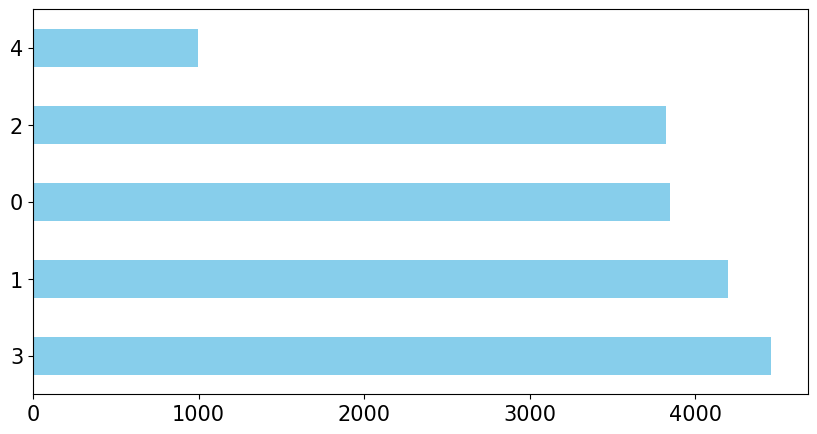

In [594]:
# Find out the avergage of longtitude and latitude for both train and test
if UJIInddorLoc_DF_train5['LONGITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_train5 = calculate_average(UJIInddorLoc_DF_train5,'long')

if UJIInddorLoc_DF_test5['LONGITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_test5 = calculate_average(UJIInddorLoc_DF_test5,'long')
    
if UJIInddorLoc_DF_train5['LATITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_train5 = calculate_average(UJIInddorLoc_DF_train5,'lat')
    
if UJIInddorLoc_DF_test5['LATITUDE'].astype(str).str.contains(',').any():
    UJIInddorLoc_DF_test5 = calculate_average(UJIInddorLoc_DF_test5,'lat')
    
print(UJIInddorLoc_DF_train5['LONGITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_test5['LONGITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_train5['LATITUDE'].head(5),"\n")
print(UJIInddorLoc_DF_test5['LATITUDE'].head(5))

Original_DF_FLOOR5 = UJIInddorLoc_DF_train5['FLOOR'].value_counts()
Original_DF_FLOOR5.plot(kind='barh', figsize=(10,5), fontsize=15, color='skyblue')

# Evaluate Data
Training/validation set

In [595]:
print("Building 0",UJIInddorLoc_DF_train5.loc[UJIInddorLoc_DF_train5["BUILDINGID"] == 0]["FLOOR"].unique()) # building 0 has 4 floors
print("\nBuilding 1",UJIInddorLoc_DF_train5.loc[UJIInddorLoc_DF_train5["BUILDINGID"] == 1]["FLOOR"].unique()) # building 1 has 4 floors
print("\nBuilding 2",UJIInddorLoc_DF_train5.loc[UJIInddorLoc_DF_train5["BUILDINGID"] == 2]["FLOOR"].unique()) # building 2 has 5 floors
UJIInddorLoc_DF_train5.columns.values

Building 0 [3 0 2 1]

Building 1 [0 1 2 3]

Building 2 [2 1 4 3 0]


array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

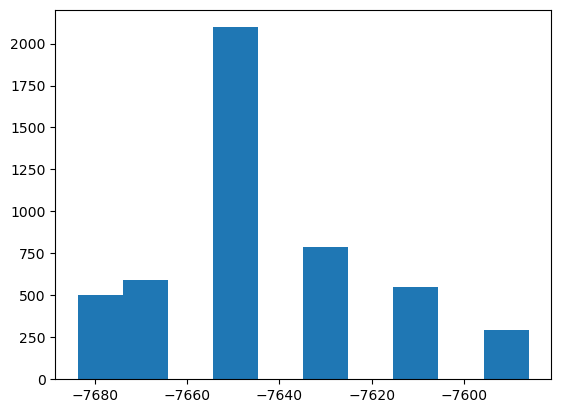

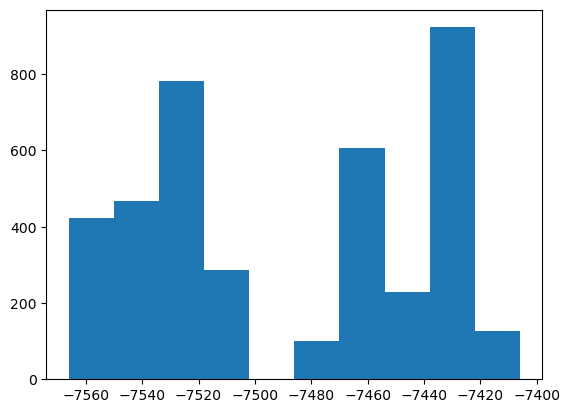

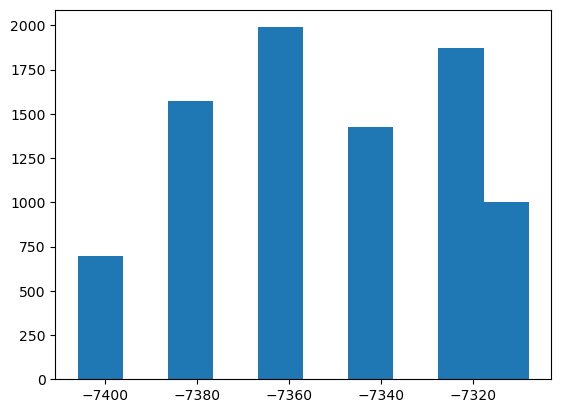

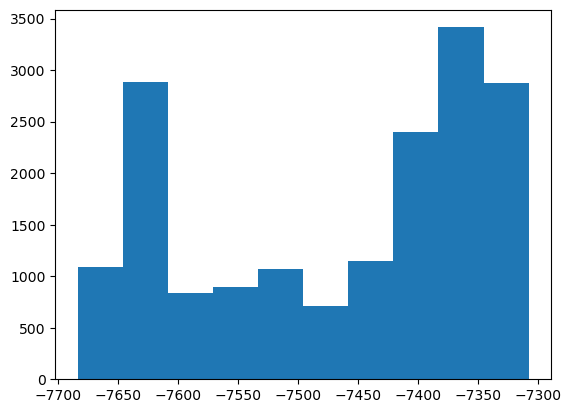

Missing Values: False


In [596]:
plt.hist(UJIInddorLoc_DF_train5.loc[UJIInddorLoc_DF_train5["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()
# Almost all fingerprints were collected right outside the door to each 
# fingerprint's SPACEID location.
# Building 0 fingerprints were collected by just 2 devices (and 2 separate 
# users). Not a lot of variety in different devices.

plt.hist(UJIInddorLoc_DF_train5.loc[UJIInddorLoc_DF_train5["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

plt.hist(UJIInddorLoc_DF_train5.loc[UJIInddorLoc_DF_train5["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

plt.hist(UJIInddorLoc_DF_train5["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

# check for missing values
pd.isnull(UJIInddorLoc_DF_train5)
print("Missing Values:",pd.isnull(UJIInddorLoc_DF_train5).values.any())

In [597]:
print("Building 0",UJIInddorLoc_DF_test5.loc[UJIInddorLoc_DF_test5["BUILDINGID"] == 0]["FLOOR"].unique()) # building 0 has 4 floors
print("\nBuilding 1",UJIInddorLoc_DF_test5.loc[UJIInddorLoc_DF_test5["BUILDINGID"] == 1]["FLOOR"].unique()) # building 1 has 4 floors
print("\nBuilding 2",UJIInddorLoc_DF_test5.loc[UJIInddorLoc_DF_test5["BUILDINGID"] == 2]["FLOOR"].unique()) # building 2 has 5 floors
UJIInddorLoc_DF_test5.columns.values

Building 0 [3 0 1 2]

Building 1 [1 2 0]

Building 2 [1 4 0 2 3]


array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

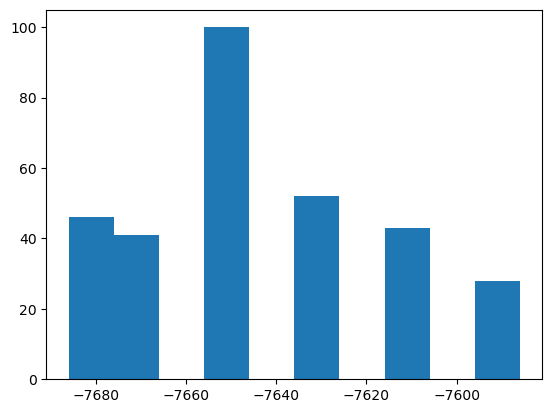

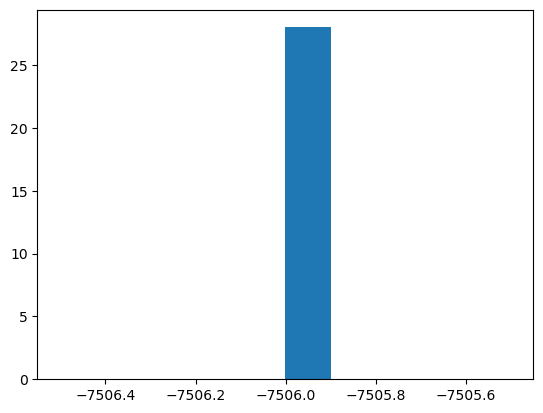

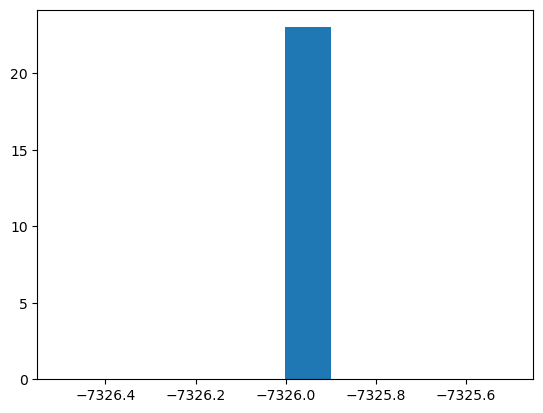

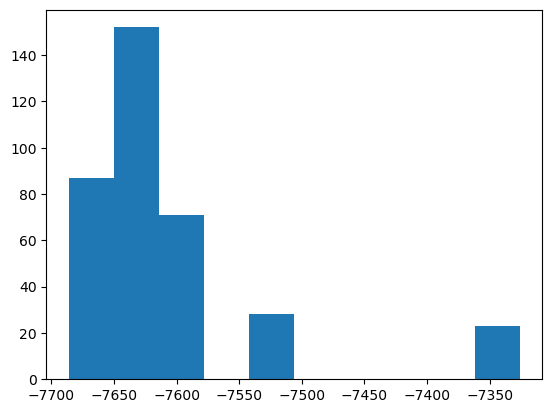

Missing Values: False


In [598]:
plt.hist(UJIInddorLoc_DF_test5.loc[UJIInddorLoc_DF_test5["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test5.loc[UJIInddorLoc_DF_test5["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test5.loc[UJIInddorLoc_DF_test5["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()

plt.hist(UJIInddorLoc_DF_test5["LONGITUDE"])
plt.show()

# check for missing values
pd.isnull(UJIInddorLoc_DF_test5)
print("Missing Values:",pd.isnull(UJIInddorLoc_DF_test5).values.any())

# Preprocess Data and Feature Engineering
Training/validation Set

In [599]:
# Fingerprint data representation: positive-value representation for all WAPs.
# Original representation: -104 to 0 (weak to strong), 100 for no signal.
# New represenation: 1 to 105 (weak to strong), 0 for no signal.
UJIInddorLoc_DF_train5.iloc[:, 0:520].min().min() # minimum WAP is -104 dBm
train_set_P5 = UJIInddorLoc_DF_train5.copy()
train_set_P5.iloc[:, 0:520] = np.where(train_set_P5.iloc[:, 0:520] <= 0, 
                train_set_P5.iloc[:, 0:520] + 105, 
                train_set_P5.iloc[:, 0:520] - 100) 

# Feature Scaling - do not center - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

# Create a single label for the model to predict. FLOOR, LATITUDE, FLOOR, and 
# BUILDINGID pinpoints the exact location of a user inside a building. Stack 
# train set and test set first before assigning unique location so that 
# identical locations are assigned the same UNIQUELOCATION value.
combined5 = pd.concat([train_set_P5, UJIInddorLoc_DF_test5]) # stack vertically
combined5 = combined5.assign(UNIQUELOCATION = (combined5['LONGITUDE'].astype(str) + '_' + combined5['LATITUDE'].astype(str) + '_' + combined5['FLOOR'].astype(str) + '_' + combined5['BUILDINGID'].astype(str)).astype('category').cat.codes)
len(combined5["UNIQUELOCATION"].unique()) # 287 unique locations


# split again
train_set_PU5 = combined5.iloc[0:17327, :]
test_set_U5 = combined5.iloc[17327:17688, :]

# Change variable types
train_set_PU5["UNIQUELOCATION"] = train_set_PU5["UNIQUELOCATION"].astype("category")
print(train_set_PU5.dtypes)

X_train5 = train_set_PU5.iloc[:, 0:520]
y_train5 = train_set_PU5.iloc[:, 520:530]

WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object


/var/folders/31/mntbwvv97f9b6y8w30p020b00000gn/T/ipykernel_26549/2852814961.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_PU5["UNIQUELOCATION"] = train_set_PU5["UNIQUELOCATION"].astype("category")


Test Set

In [600]:
# Fingerprint data representation
test_set_PU5 = test_set_U5.copy()
test_set_PU5.iloc[:, 0:520] = np.where(test_set_PU5.iloc[:, 0:520] <= 0, test_set_PU5.iloc[:, 0:520] + 105, test_set_PU5.iloc[:, 0:520] - 100) 

# Feature Scaling - do not center this data - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

test_set_PU5["UNIQUELOCATION"] = test_set_PU5["UNIQUELOCATION"].astype("category")
print(test_set_PU5.dtypes)

WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object


In [601]:
X_test5 = test_set_PU5.iloc[:, 0:520]
y_test5 = test_set_PU5.iloc[:, 520:530]

# Create a reference table for looking up the LONGITUDE, LATITUDE, FLOOR, and 
# BUILDINGID associated with each UNIQUELOCATION value.
ref_table5 = pd.concat([y_train5.iloc[:, [0,1,2,3,9]], y_test5.iloc[:, [0,1,2,3,9]]])
ref_table5 = ref_table5.drop_duplicates()

#save_data(X_train5, 'X_train_rf5.csv')
#save_data(y_train5, 'y_train_rf5.csv')
#save_data(X_test5, 'X_test_rf5.csv')
#save_data(y_test5, 'y_test_rf5.csv')

#--- load data ---#
#X_train5 = pd.read_csv('X_train_rf5.csv', index_col = 0)
#y_train5 = pd.read_csv('y_train_rf5.csv', index_col = 0)
#X_test5 = pd.read_csv('X_test_rf5.csv', index_col = 0)
#y_test5 = pd.read_csv('y_test_rf5.csv', index_col = 0)

#-- delete unneeded datasets created during preprocessing to free up memory --#
del UJIInddorLoc_DF_train5, train_set_P5, train_set_PU5, UJIInddorLoc_DF_test5, test_set_U5, test_set_PU5, combined5

# 5.1 RANDOM FOREST

In [602]:
file_exists = os.path.exists('Random_Forest_5_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = RandomForestClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters1,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result5 = grid.fit(X_train5, y_train5.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result5.best_estimator_)
    print(grid_result5.best_score_)
    print(grid_result5.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Random_Forest_5_1.json', 'w') as json_file:
        json.dump(grid_result5.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result5.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['RandomForestClassifier']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [603]:
read = open('Random_Forest_1_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
n_estimators = best[3]

start_train = time.time()
grid_result5 = RandomForestClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                n_estimators = n_estimators)

# Train the model
grid_result5.fit(X_train5, y_train5.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred5 = grid_result5.predict(X_test5)
print("Mean:",np.mean(y_pred5 == y_test5.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos5 = y_test5.iloc[:, 0:2].values 
y_test_floor5 = y_test5.iloc[:, 2].values
y_test_building5 = y_test5.iloc[:, 3].values

dict_loc = {}
m_total = ref_table5.shape[0]
for i in range(m_total):
    key = int(ref_table5.iloc[i]['UNIQUELOCATION'])
    value = ref_table5.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 0:2] 
y_pred_floor5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 2]
y_pred_building5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 3]

# position errors for each test set example, in order as they appear
D_error5 = euclidean(y_test_pos5, y_pred_pos5)
# sorted   
sorted_D_error5 = sorted(D_error5)

m_test5 = y_test5.shape[0]
mean_error5 = np.mean(D_error5) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error5[math.ceil(m_test5*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error5[math.ceil(m_test5*0.50) - 1] # meters
percentile_75th = sorted_D_error5[math.ceil(m_test5*0.75) - 1] # meters
percentile_95th = sorted_D_error5[math.ceil(m_test5*0.95) - 1] # meters
percentile_100th = sorted_D_error5[math.ceil(m_test5*1.00) - 1] # meters
building_hitrate5 = np.mean(y_test_building5 == y_pred_building5)
floor_hitrate5 = np.mean(y_test_floor5 == y_pred_floor5)

mean_error_5_1 = np.mean(D_error5) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_5_1)
Random_Forest_Dict['Differential Privacy'] = mean_error_5_1

Best Parameters Saved: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 60}
Mean: 0.575
Mean Error: 4.862229679938369


# 5.2 DECISION TREE

In [604]:
file_exists = os.path.exists('Decision_Tree_5_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = DecisionTreeClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters2,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result5 = grid.fit(X_train5, y_train5.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result5.best_estimator_)
    print(grid_result5.best_score_)
    print(grid_result5.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Decision_Tree_5_2.json', 'w') as json_file:
        json.dump(grid_result5.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result5.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['DecisionTree']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [605]:
read = open('Decision_Tree_5_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
grid_result5 = DecisionTreeClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
grid_result5.fit(X_train5, y_train5.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred5 = grid_result5.predict(X_test5)
print("Mean:",np.mean(y_pred5 == y_test5.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos5 = y_test5.iloc[:, 0:2].values 
y_test_floor5 = y_test5.iloc[:, 2].values
y_test_building5 = y_test5.iloc[:, 3].values

dict_loc = {}
m_total = ref_table5.shape[0]
for i in range(m_total):
    key = int(ref_table5.iloc[i]['UNIQUELOCATION'])
    value = ref_table5.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 0:2] 
y_pred_floor5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 2]
y_pred_building5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 3]

# position errors for each test set example, in order as they appear
D_error5 = euclidean(y_test_pos5, y_pred_pos5)
# sorted   
sorted_D_error5 = sorted(D_error5)

m_test5 = y_test5.shape[0]
mean_error5 = np.mean(D_error5) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error5[math.ceil(m_test5*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error5[math.ceil(m_test5*0.50) - 1] # meters
percentile_75th = sorted_D_error5[math.ceil(m_test5*0.75) - 1] # meters
percentile_95th = sorted_D_error5[math.ceil(m_test5*0.95) - 1] # meters
percentile_100th = sorted_D_error5[math.ceil(m_test5*1.00) - 1] # meters
building_hitrate5 = np.mean(y_test_building5 == y_pred_building5)
floor_hitrate5 = np.mean(y_test_floor5 == y_pred_floor5)

mean_error_5_2 = np.mean(D_error5) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_5_2)
Decision_Tree_Dict['Differential Privacy'] = mean_error_5_2

Best Parameters Saved: {'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 60, 'random_state': 42, 'splitter': 'best'}
Mean: 0.325
Mean Error: 19.763152333357283


# 5.3 KNN

In [606]:
file_exists = os.path.exists('KNN_5_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = KNeighborsClassifier()

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters3,
                        scoring = scoring,
                        cv = 2, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result5 = grid.fit(X_train5, y_train5.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result5.best_estimator_)
    print(grid_result5.best_score_)
    print(grid_result5.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('KNN_5_3.json', 'w') as json_file:
        json.dump(grid_result5.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result5.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['KNN']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [607]:
read = open('KNN_5_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
grid_result5 = KNeighborsClassifier(algorithm = algorithm,  leaf_size = leaf_size, metric = metric, \
                                n_neighbors = n_neighbors, p = p, weights = weights)

# Train the model
grid_result5.fit(X_train5, y_train5.iloc[:, 9].squeeze())



#--- test set metrics ---#
y_pred5 = grid_result5.predict(X_test5)
print("Mean:",np.mean(y_pred5 == y_test5.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos5 = y_test5.iloc[:, 0:2].values 
y_test_floor5 = y_test5.iloc[:, 2].values
y_test_building5 = y_test5.iloc[:, 3].values

dict_loc = {}
m_total = ref_table5.shape[0]
for i in range(m_total):
    key = int(ref_table5.iloc[i]['UNIQUELOCATION'])
    value = ref_table5.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 0:2] 
y_pred_floor5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 2]
y_pred_building5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 3]

# position errors for each test set example, in order as they appear
D_error5 = euclidean(y_test_pos5, y_pred_pos5)
# sorted   
sorted_D_error5 = sorted(D_error5)

m_test5 = y_test5.shape[0]
mean_error5 = np.mean(D_error5) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error5[math.ceil(m_test5*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error5[math.ceil(m_test5*0.50) - 1] # meters
percentile_75th = sorted_D_error5[math.ceil(m_test5*0.75) - 1] # meters
percentile_95th = sorted_D_error5[math.ceil(m_test5*0.95) - 1] # meters
percentile_100th = sorted_D_error5[math.ceil(m_test5*1.00) - 1] # meters
building_hitrate5 = np.mean(y_test_building5 == y_pred_building5)
floor_hitrate5 = np.mean(y_test_floor5 == y_pred_floor5)

mean_error_5_3 = np.mean(D_error5) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_5_3)
KNN_Dict['Differential Privacy'] = mean_error_5_3

Best Parameters Saved: {'algorithm': 'kd_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
Mean: 0.49166666666666664
Mean Error: 7.0804201028082705


# 5.4 EXTRA TREE

In [608]:
file_exists = os.path.exists('Extra_Tree_5_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = ExtraTreeClassifier(random_state = 0)

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters4,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result5 = grid.fit(X_train5, y_train5.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result5.best_estimator_)
    print(grid_result5.best_score_)
    print(grid_result5.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Extra_Tree_5_4.json', 'w') as json_file:
        json.dump(grid_result5.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result5.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['ExtraTree']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [609]:
read = open('Extra_Tree_2_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
grid_result5 = ExtraTreeClassifier(criterion = criterion,  max_depth = max_depth, max_features = max_features, \
                                min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
grid_result5.fit(X_train5, y_train5.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred5 = grid_result5.predict(X_test5)
print("Mean:",np.mean(y_pred5 == y_test5.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos5 = y_test5.iloc[:, 0:2].values 
y_test_floor5 = y_test5.iloc[:, 2].values
y_test_building5 = y_test5.iloc[:, 3].values

dict_loc = {}
m_total = ref_table5.shape[0]
for i in range(m_total):
    key = int(ref_table5.iloc[i]['UNIQUELOCATION'])
    value = ref_table5.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 0:2] 
y_pred_floor5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 2]
y_pred_building5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 3]

# position errors for each test set example, in order as they appear
D_error5 = euclidean(y_test_pos5, y_pred_pos5)
# sorted   
sorted_D_error5 = sorted(D_error5)

m_test5 = y_test5.shape[0]
mean_error5 = np.mean(D_error5) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error5[math.ceil(m_test5*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error5[math.ceil(m_test5*0.50) - 1] # meters
percentile_75th = sorted_D_error5[math.ceil(m_test5*0.75) - 1] # meters
percentile_95th = sorted_D_error5[math.ceil(m_test5*0.95) - 1] # meters
percentile_100th = sorted_D_error5[math.ceil(m_test5*1.00) - 1] # meters
building_hitrate5 = np.mean(y_test_building5 == y_pred_building5)
floor_hitrate5 = np.mean(y_test_floor5 == y_pred_floor5)

mean_error_5_4 = np.mean(D_error5) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_5_4)
Extra_Tree_Dict['Differential Privacy'] = mean_error_5_4

Best Parameters Saved: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 20, 'random_state': 42, 'splitter': 'best'}
Mean: 0.36944444444444446
Mean Error: 15.660321278183222


# 5.5 VOTING

In [610]:
file_exists = os.path.exists('Voting_5_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:

    # Using cross-validation, train best random forest model to predict 
    # UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
    # for cross-validation and on the training set. We report location error metrics
    # on the test set.

    # Select model
    classifier = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)])

    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters5,
                        scoring = scoring,
                        cv = 5, # the original setting cv = 10 will cause memory issues for free colab accounts, cv=2 restricts the k-fold cross validation to 2. 
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

    tic = time.time()
    grid_result5 = grid.fit(X_train5, y_train5.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    print(run_time)
    print(grid_result5.best_estimator_)
    print(grid_result5.best_score_)
    print(grid_result5.best_params_)
    
    # Below code will work based on Windows
    value=platform.platform()
    array = value.split("-")
    if array[0] == 'macOS':
            os.system('say "Grid Search complete."')
    else:
        import winsound; winsound.Beep(frequency = 500, duration = 1000)  
    
    with open('Voting_5_5.json', 'w') as json_file:
        json.dump(grid_result5.best_params_, json_file)
        
    #--- cross validation metrics and training set metrics (average of folds) ----#
    cv_results_ = pd.DataFrame.from_dict(grid_result5.cv_results_) 
    cv_results_.insert(loc = 0, column = 'Model', 
                       value = ['Voting']*cv_results_.shape[0])
    cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                       value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
    cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                       value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
    with open('tuning_rf.csv', 'a') as f:
        cv_results_.to_csv(f, header = True)

File exists: True


In [613]:
read = open('Voting_5_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
voting = best[0]

start_train = time.time()
grid_result5 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting = voting)

# Train the model
grid_result5.fit(X_train5, y_train5.iloc[:, 9].squeeze())

#--- test set metrics ---#
y_pred5 = grid_result5.predict(X_test5)
print("Mean:",np.mean(y_pred5 == y_test5.iloc[:, 9]))
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.


y_test_pos5 = y_test5.iloc[:, 0:2].values 
y_test_floor5 = y_test5.iloc[:, 2].values
y_test_building5 = y_test5.iloc[:, 3].values

dict_loc = {}
m_total = ref_table5.shape[0]
for i in range(m_total):
    key = int(ref_table5.iloc[i]['UNIQUELOCATION'])
    value = ref_table5.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 0:2] 
y_pred_floor5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 2]
y_pred_building5 = np.asarray([dict_loc[i] for i in y_pred5])[:, 3]

# position errors for each test set example, in order as they appear
D_error5 = euclidean(y_test_pos5, y_pred_pos5)
# sorted   
sorted_D_error5 = sorted(D_error5)

m_test5 = y_test5.shape[0]
mean_error5 = np.mean(D_error5) # meters, this is the main performance metric for our task
percentile_25th = sorted_D_error5[math.ceil(m_test5*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error5[math.ceil(m_test5*0.50) - 1] # meters
percentile_75th = sorted_D_error5[math.ceil(m_test5*0.75) - 1] # meters
percentile_95th = sorted_D_error5[math.ceil(m_test5*0.95) - 1] # meters
percentile_100th = sorted_D_error5[math.ceil(m_test5*1.00) - 1] # meters
building_hitrate5 = np.mean(y_test_building5 == y_pred_building5)
floor_hitrate5 = np.mean(y_test_floor5 == y_pred_floor5)

mean_error_5_5 = np.mean(D_error5) # meters, this is the main performance metric for our task 9.1
print("Mean Error:",mean_error_5_5)
Voting_Dict['Differential Privacy'] = mean_error_5_5

Best Parameters Saved: {'voting': 'hard'}


/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean: 0.49444444444444446
Mean Error: 43.90957570413498


In [615]:
# Print all the dictionaries
print(Random_Forest_Dict)
print(Decision_Tree_Dict)
print(KNN_Dict)
print(Extra_Tree_Dict)
print(Voting_Dict)

{'Original': 8.645534551156816, 'k-Anonymity': 10.319470106511359, 'Population Uniqueness': 214.59284191624715, 'Avg Re-identification Risk': 11.431867425609223, 'Differential Privacy': 4.862229679938369}
{'Original': 63.31222592905285, 'k-Anonymity': 46.33538074449667, 'Population Uniqueness': 32.23560832742209, 'Avg Re-identification Risk': 29.863062156979773, 'Differential Privacy': 19.763152333357283}
{'Original': 12.118167980573228, 'k-Anonymity': 24.722158142247345, 'Population Uniqueness': 17.07323306980266, 'Avg Re-identification Risk': 14.203145319120477, 'Differential Privacy': 7.0804201028082705}
{'Original': 20.71474278015889, 'k-Anonymity': 30.00653665548994, 'Population Uniqueness': 21.589957145073285, 'Avg Re-identification Risk': 21.478526787693948, 'Differential Privacy': 15.660321278183222}
{'Original': 10.319470106511359, 'k-Anonymity': 22.41302848138435, 'Population Uniqueness': 12.456472770300431, 'Avg Re-identification Risk': 12.129120764205966, 'Differential Priv

# DATA VISUALIZATION

### A. k-Anonymity Utility Loss Plot

(16, 13)


[Text(0, 0, '2.8'),
 Text(0, 0, '2.8'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '5.85'),
 Text(0, 0, '5.85')]

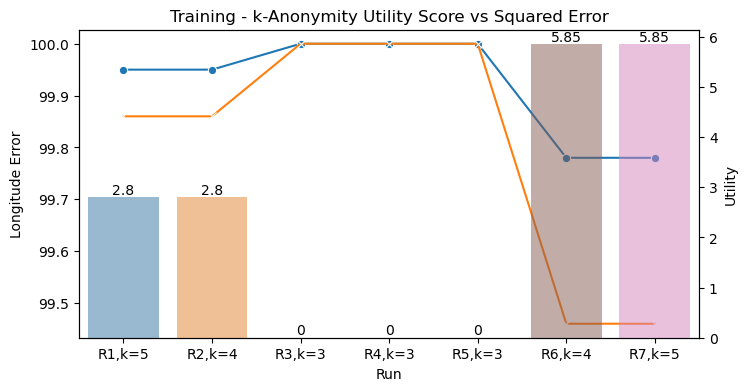

In [402]:
ARX_Utility_Loss_k_Anonymity_df = pd.read_csv('ARX_Utility Loss_k-Anonymity.csv')
print(ARX_Utility_Loss_k_Anonymity_df.shape)

matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(8,4))

# sns.lineplot(data = ARX_Utility_Loss_k_Anonymity_df.iloc[0:7]['Longitude Error'],marker='o', sort = False, ax=ax1)
# sns.lineplot(data = ARX_Utility_Loss_k_Anonymity_df.iloc[0:7]['Latitude Error'],marker='x', sort = False, ax=ax1)

sns.lineplot(data = ARX_Utility_Loss_k_Anonymity_df.iloc[0:7], x='Run', y = 'Longitude Error',marker='o', sort = False, ax=ax1)
sns.lineplot(data = ARX_Utility_Loss_k_Anonymity_df.iloc[0:7],  x='Run', y = 'Latitude Error',marker='x', sort = False, ax=ax1)


ax2 = ax1.twinx()

sns.barplot(data = ARX_Utility_Loss_k_Anonymity_df.iloc[0:7], x='Run', y='Utility', alpha=0.5, ax=ax2).set(title="Training - k-Anonymity Utility Score vs Squared Error")
ax2.bar_label(ax2.containers[0])

[Text(0, 0, '16.41'),
 Text(0, 0, '16.41'),
 Text(0, 0, '16.41'),
 Text(0, 0, '15.1'),
 Text(0, 0, '15.1'),
 Text(0, 0, '44.75'),
 Text(0, 0, '44.75'),
 Text(0, 0, '44.75'),
 Text(0, 0, '44.75')]

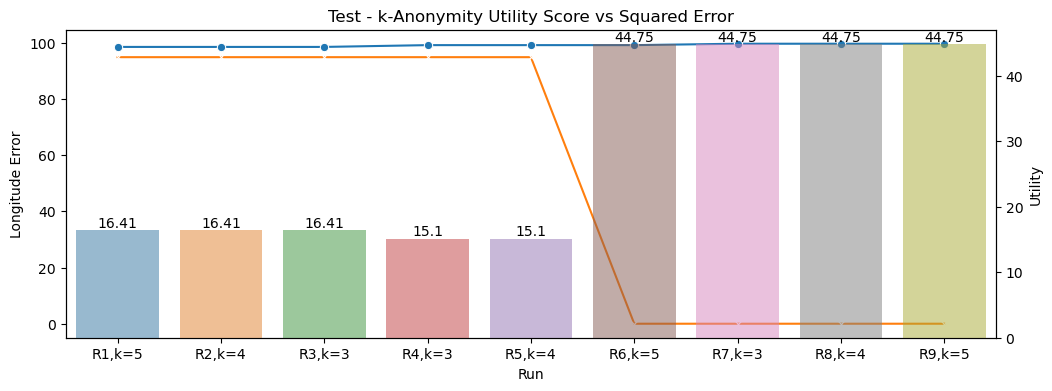

In [403]:
matplotlib.rc_file_defaults()
ax3 = sns.set_style(style=None, rc=None )
fig, ax3 = plt.subplots(figsize=(12,4))

sns.lineplot(data = ARX_Utility_Loss_k_Anonymity_df.iloc[7:16], x='Run', y = 'Longitude Error',marker='o', sort = False, ax=ax3)
sns.lineplot(data = ARX_Utility_Loss_k_Anonymity_df.iloc[7:16],  x='Run', y = 'Latitude Error',marker='x', sort = False, ax=ax3)

ax4 = ax3.twinx()
sns.barplot(data = ARX_Utility_Loss_k_Anonymity_df.iloc[7:16], x='Run', y='Utility', alpha=0.5, ax=ax4).set(title="Test - k-Anonymity Utility Score vs Squared Error")
ax4.bar_label(ax4.containers[0])

### B. Population Uniqueness Utility Loss Plot

(13, 13)


[Text(0, 0, '5.85'),
 Text(0, 0, '5.85'),
 Text(0, 0, '5.85'),
 Text(0, 0, '5.85'),
 Text(0, 0, '3.41'),
 Text(0, 0, '3.41'),
 Text(0, 0, '6.47'),
 Text(0, 0, '7.4')]

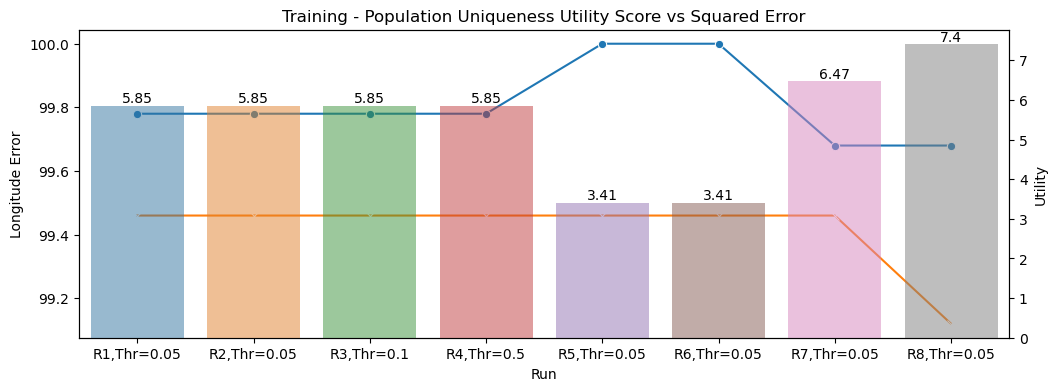

In [409]:
ARX_Utility_Loss_Population_Uniqueness_df = pd.read_csv('ARX_Utility Loss_Population Uniqueness.csv')
print(ARX_Utility_Loss_Population_Uniqueness_df.shape)

matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,4))

sns.lineplot(data = ARX_Utility_Loss_Population_Uniqueness_df.iloc[0:8], x='Run', y = 'Longitude Error',marker='o', sort = False, ax=ax1)
sns.lineplot(data = ARX_Utility_Loss_Population_Uniqueness_df.iloc[0:8],  x='Run', y = 'Latitude Error',marker='x', sort = False, ax=ax1)


ax2 = ax1.twinx()

sns.barplot(data = ARX_Utility_Loss_Population_Uniqueness_df.iloc[0:8], x='Run', y='Utility', alpha=0.5, ax=ax2).set(title="Training - Population Uniqueness Utility Score vs Squared Error")
ax2.bar_label(ax2.containers[0])

[Text(0, 0, '2.66'),
 Text(0, 0, '7.12'),
 Text(0, 0, '6.14'),
 Text(0, 0, '5.5'),
 Text(0, 0, '6.36')]

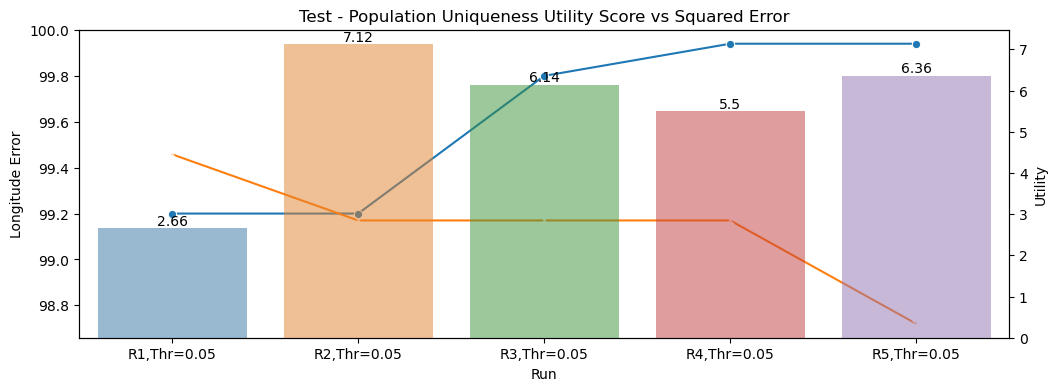

In [627]:
matplotlib.rc_file_defaults()
ax3 = sns.set_style(style=None, rc=None )
fig, ax3 = plt.subplots(figsize=(12,4))

sns.lineplot(data = ARX_Utility_Loss_Population_Uniqueness_df.iloc[8:14], x='Run', y = 'Longitude Error',marker='o', sort = False, ax=ax3)
sns.lineplot(data = ARX_Utility_Loss_Population_Uniqueness_df.iloc[8:14],  x='Run', y = 'Latitude Error',marker='x', sort = False, ax=ax3)

ax4 = ax3.twinx()
sns.barplot(data = ARX_Utility_Loss_Population_Uniqueness_df.iloc[8:14], x='Run', y='Utility', alpha=0.5, ax=ax4).set(title="Test - Population Uniqueness Utility Score vs Squared Error")
ax4.bar_label(ax4.containers[0])

### C. Average Re-identification risk Utility Loss Plot

(11, 13)


[Text(0, 0, '2.8'),
 Text(0, 0, '2.8'),
 Text(0, 0, '3.42'),
 Text(0, 0, '4.04'),
 Text(0, 0, '4.04'),
 Text(0, 0, '4.96'),
 Text(0, 0, '4.96')]

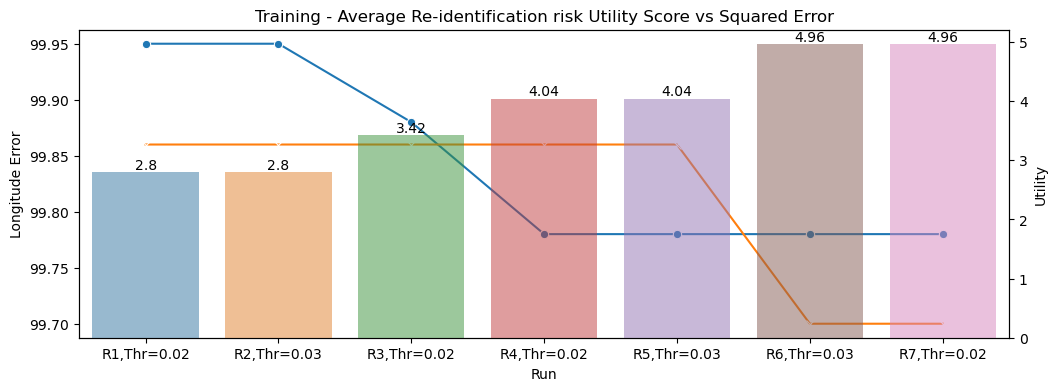

In [628]:
ARX_Utility_Loss_Average_reidentification_risk_df = pd.read_csv('ARX_Utility Loss_Average re-identification risk.csv')
print(ARX_Utility_Loss_Average_reidentification_risk_df.shape)

matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,4))

sns.lineplot(data = ARX_Utility_Loss_Average_reidentification_risk_df.iloc[0:7], x='Run', y = 'Longitude Error',marker='o', sort = False, ax=ax1)
sns.lineplot(data = ARX_Utility_Loss_Average_reidentification_risk_df.iloc[0:7],  x='Run', y = 'Latitude Error',marker='x', sort = False, ax=ax1)


ax2 = ax1.twinx()

sns.barplot(data = ARX_Utility_Loss_Average_reidentification_risk_df.iloc[0:7], x='Run', y='Utility', alpha=0.5, ax=ax2).set(title="Training - Average Re-identification risk Utility Score vs Squared Error")
ax2.bar_label(ax2.containers[0])

[Text(0, 0, '5.84'),
 Text(0, 0, '8.34'),
 Text(0, 0, '8.34'),
 Text(0, 0, '8.34')]

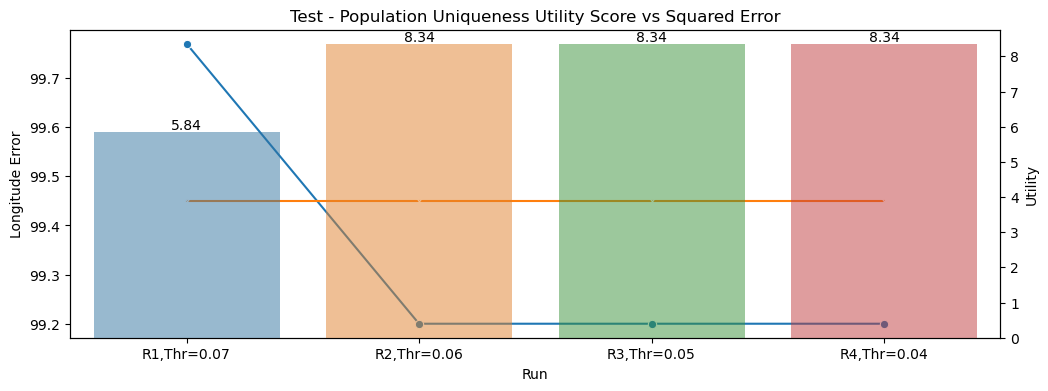

In [528]:
matplotlib.rc_file_defaults()
ax3 = sns.set_style(style=None, rc=None )
fig, ax3 = plt.subplots(figsize=(12,4))

sns.lineplot(data = ARX_Utility_Loss_Average_reidentification_risk_df.iloc[7:11], x='Run', y = 'Longitude Error',marker='o', sort = False, ax=ax3)
sns.lineplot(data = ARX_Utility_Loss_Average_reidentification_risk_df.iloc[7:11],  x='Run', y = 'Latitude Error',marker='x', sort = False, ax=ax3)

ax4 = ax3.twinx()
sns.barplot(data = ARX_Utility_Loss_Average_reidentification_risk_df.iloc[7:11], x='Run', y='Utility', alpha=0.5, ax=ax4).set(title="Test - Population Uniqueness Utility Score vs Squared Error")
ax4.bar_label(ax4.containers[0])

### Differential Privacy Utility Loss Plot

(7, 13)


[Text(0, 0, '10.98'),
 Text(0, 0, '9.54'),
 Text(0, 0, '17.02'),
 Text(0, 0, '20.29')]

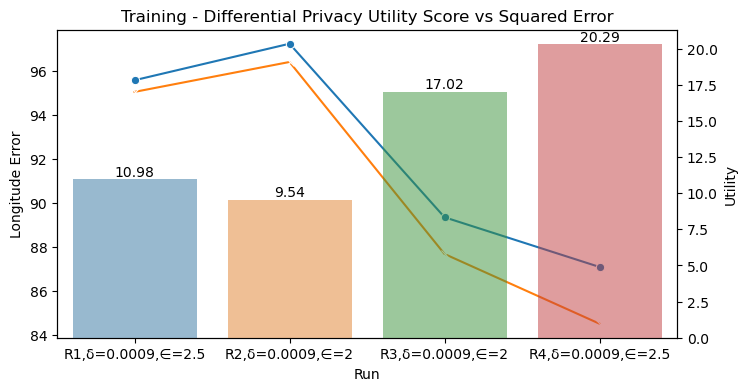

In [629]:
ARX_Utility_Loss_Differential_Privacy_df = pd.read_csv('ARX_Utility Loss_Differential Privacy Loss.csv')
print(ARX_Utility_Loss_Differential_Privacy_df.shape)

matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(8,4))

sns.lineplot(data = ARX_Utility_Loss_Differential_Privacy_df.iloc[0:4], x='Run', y = 'Longitude Error',marker='o', sort = False, ax=ax1)
sns.lineplot(data = ARX_Utility_Loss_Differential_Privacy_df.iloc[0:4],  x='Run', y = 'Latitude Error',marker='x', sort = False, ax=ax1)


ax2 = ax1.twinx()

sns.barplot(data = ARX_Utility_Loss_Differential_Privacy_df.iloc[0:4], x='Run', y='Utility', alpha=0.5, ax=ax2).set(title="Training - Differential Privacy Utility Score vs Squared Error")
ax2.bar_label(ax2.containers[0])

[Text(0, 0, '-35.28'), Text(0, 0, '-33.71'), Text(0, 0, '-35.77')]

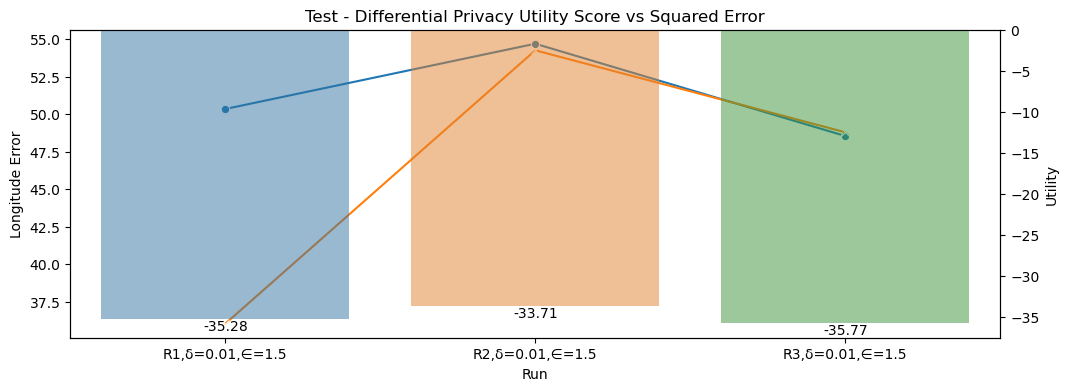

In [630]:
matplotlib.rc_file_defaults()
ax3 = sns.set_style(style=None, rc=None )
fig, ax3 = plt.subplots(figsize=(12,4))

sns.lineplot(data = ARX_Utility_Loss_Differential_Privacy_df.iloc[4:8], x='Run', y = 'Longitude Error',marker='o', sort = False, ax=ax3)
sns.lineplot(data = ARX_Utility_Loss_Differential_Privacy_df.iloc[4:8],  x='Run', y = 'Latitude Error',marker='x', sort = False, ax=ax3)

ax4 = ax3.twinx()
sns.barplot(data = ARX_Utility_Loss_Differential_Privacy_df.iloc[4:8], x='Run', y='Utility', alpha=0.5, ax=ax4).set(title="Test - Differential Privacy Utility Score vs Squared Error")
ax4.bar_label(ax4.containers[0])

### A. Random Forest Mean Error

{'Original': 8.645534551156816, 'k-Anonymity': 10.319470106511359, 'Population Uniqueness': 214.59284191624715, 'Avg Re-identification Risk': 11.431867425609223, 'Differential Privacy': 4.862229679938369}


Text(0.5, 1.0, 'Random Forest Mean Error')

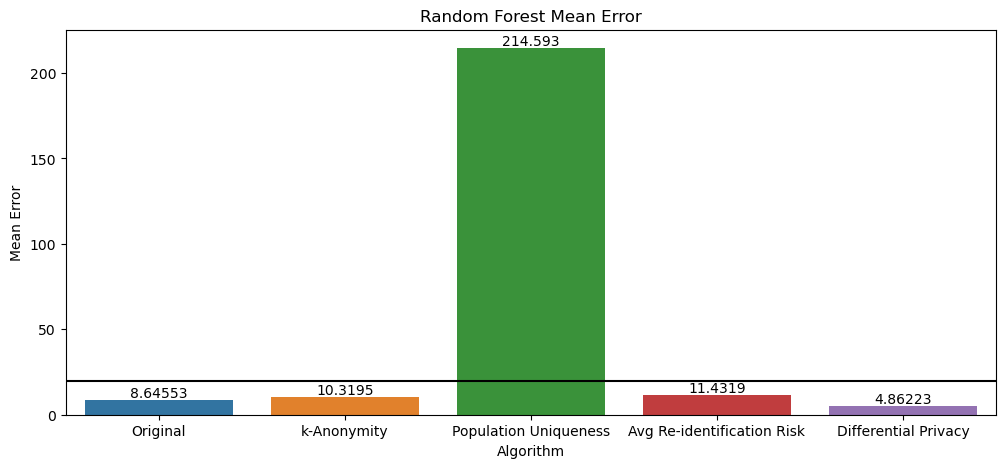

In [622]:
# Combining Prediction Errors for each algorithm in a dataframe
print(Random_Forest_Dict)

names = list(Random_Forest_Dict.keys())
values = list(Random_Forest_Dict.values())

Random_Forest_MeanError_df = pd.DataFrame({
    'Algorithm': [names[0], names[1], names[2], names[3], names[4]],
    'Mean Error': [values[0], values[1], values[2], values[3], values[4]]})


# plt.bar(range(len(Random_Forest_Dict)), values, tick_label=names)
# plt.show()

plt.figure(figsize=(12,5))
ax = sns.barplot(data=Random_Forest_MeanError_df, x='Algorithm', y='Mean Error')
plt.axhline(y=20, color='black', linestyle='-')
ax.bar_label(ax.containers[0])
ax.set_title('Random Forest Mean Error')


# Decision Tree Mean Error

{'Original': 63.31222592905285, 'k-Anonymity': 46.33538074449667, 'Population Uniqueness': 32.23560832742209, 'Avg Re-identification Risk': 29.863062156979773, 'Differential Privacy': 19.763152333357283}


Text(0.5, 1.0, 'Decision Tree Mean Error')

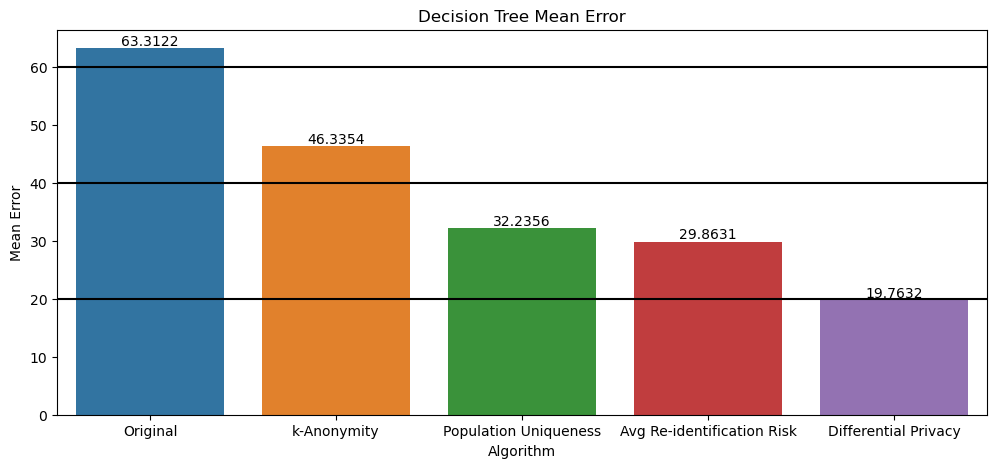

In [623]:
# Combining Prediction Errors for each algorithm in a dataframe
print(Decision_Tree_Dict)

names = list(Decision_Tree_Dict.keys())
values = list(Decision_Tree_Dict.values())

Decision_Tree_MeanError_df = pd.DataFrame({
    'Algorithm': [names[0], names[1], names[2], names[3], names[4]],
    'Mean Error': [values[0], values[1], values[2], values[3], values[4]]})


# plt.bar(range(len(Decision_Tree_Dict)), values, tick_label=names)
# plt.show()

plt.figure(figsize=(12,5))
ax = sns.barplot(data=Decision_Tree_MeanError_df, x='Algorithm', y='Mean Error')
plt.axhline(y=20, color='black', linestyle='-')
plt.axhline(y=40, color='black', linestyle='-')
plt.axhline(y=60, color='black', linestyle='-')
ax.bar_label(ax.containers[0])
ax.set_title('Decision Tree Mean Error')

# KNN Mean Error

{'Original': 12.118167980573228, 'k-Anonymity': 24.722158142247345, 'Population Uniqueness': 17.07323306980266, 'Avg Re-identification Risk': 14.203145319120477, 'Differential Privacy': 7.0804201028082705}


Text(0.5, 1.0, 'KNN Mean Error')

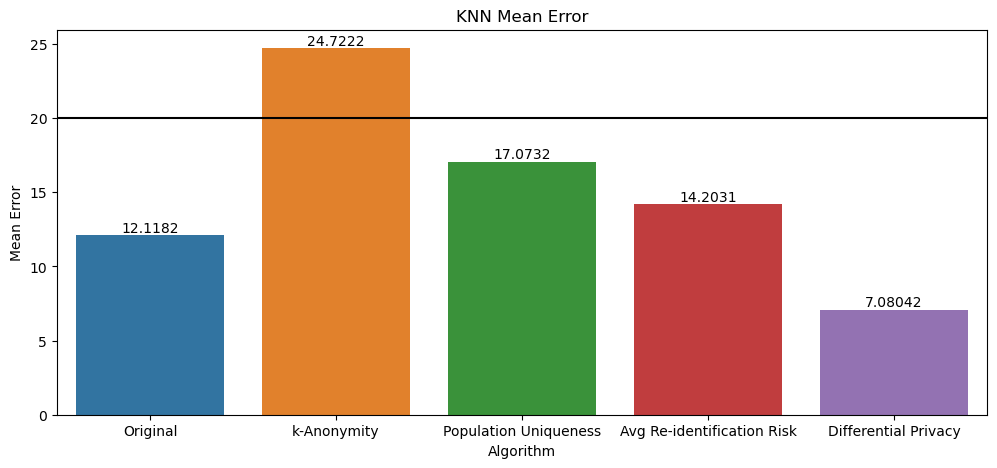

In [624]:
# Combining Prediction Errors for each algorithm in a dataframe
print(KNN_Dict)

names = list(KNN_Dict.keys())
values = list(KNN_Dict.values())

KNN_MeanError_df = pd.DataFrame({
    'Algorithm': [names[0], names[1], names[2], names[3], names[4]],
    'Mean Error': [values[0], values[1], values[2], values[3], values[4]]})


# plt.bar(range(len(KNN_Dict)), values, tick_label=names)
# plt.show()

plt.figure(figsize=(12,5))
ax = sns.barplot(data=KNN_MeanError_df, x='Algorithm', y='Mean Error')
plt.axhline(y=20, color='black', linestyle='-')
ax.bar_label(ax.containers[0])
ax.set_title('KNN Mean Error')

# Extra Tree Mean Error

{'Original': 20.71474278015889, 'k-Anonymity': 30.00653665548994, 'Population Uniqueness': 21.589957145073285, 'Avg Re-identification Risk': 21.478526787693948, 'Differential Privacy': 15.660321278183222}


Text(0.5, 1.0, 'Extra Tree Classifier Mean Error')

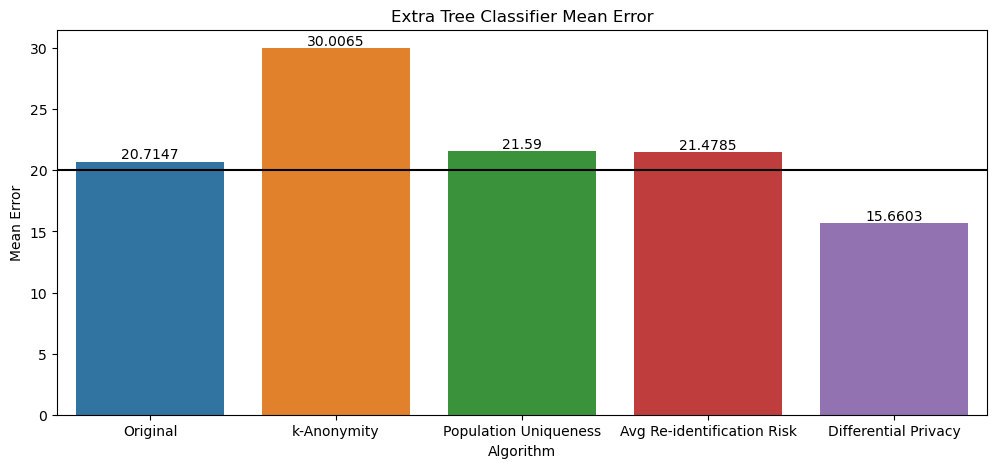

In [625]:
# Combining Prediction Errors for each algorithm in a dataframe
print(Extra_Tree_Dict)

names = list(Extra_Tree_Dict.keys())
values = list(Extra_Tree_Dict.values())

Extra_Tree_MeanError_df = pd.DataFrame({
    'Algorithm': [names[0], names[1], names[2], names[3], names[4]],
    'Mean Error': [values[0], values[1], values[2], values[3], values[4]]})


# plt.bar(range(len(Extra_Tree_Dict)), values, tick_label=names)
# plt.show()

plt.figure(figsize=(12,5))
ax = sns.barplot(data=Extra_Tree_MeanError_df, x='Algorithm', y='Mean Error')
plt.axhline(y=20, color='black', linestyle='-')
ax.bar_label(ax.containers[0])
ax.set_title('Extra Tree Classifier Mean Error')


# Voting Mean Error

{'Original': 10.319470106511359, 'k-Anonymity': 22.41302848138435, 'Population Uniqueness': 12.456472770300431, 'Avg Re-identification Risk': 12.129120764205966, 'Differential Privacy': 43.90957570413498}


Text(0.5, 1.0, 'Voting Classifier Mean Error')

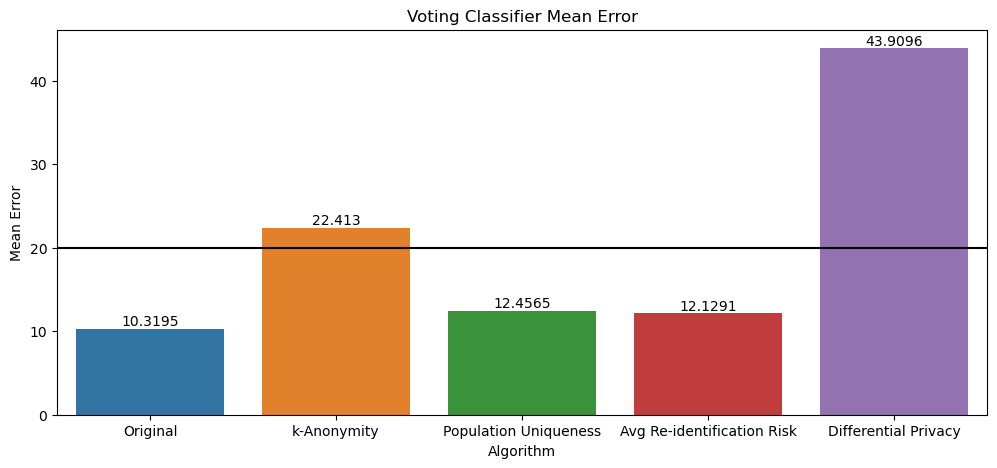

In [626]:
# Combining Prediction Errors for each algorithm in a dataframe
print(Voting_Dict)

names = list(Voting_Dict.keys())
values = list(Voting_Dict.values())

Voting_MeanError_df = pd.DataFrame({
    'Algorithm': [names[0], names[1], names[2], names[3], names[4]],
    'Mean Error': [values[0], values[1], values[2], values[3], values[4]]})


# plt.bar(range(len(Voting_Dict)), values, tick_label=names)
# plt.show()

plt.figure(figsize=(12,5))
ax = sns.barplot(data=Voting_MeanError_df, x='Algorithm', y='Mean Error')
plt.axhline(y=20, color='black', linestyle='-')
ax.bar_label(ax.containers[0])
ax.set_title('Voting Classifier Mean Error')

# End of the program